In [1]:
import torch
torch.manual_seed(42)
import torch.nn as nn
import torchvision.models as models
from libauc.optimizers import SGD, Adam,PESG
from libauc.losses import CrossEntropyLoss, AUCMLoss
from torch.utils.data import DataLoader, random_split
import os
os.environ['medmnist_data_dir'] = 'D:\\Download\\CSCE633\\project\\data'
import medmnist
from medmnist.dataset import BreastMNIST
# PneumoniaMNIST, ChestMNIST, NoduleMNIST3D, AdrenalMNIST3D, VesselMNIST3D, SynapseMNIST3D
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score
from medmnist import INFO, Evaluator
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

d:\adahx\anaconda3\envs\new_env_project\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


parameters

In [2]:
data_flag = 'breastmnist'

NUM_EPOCHS = 200
BATCH_SIZE = 64
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

preprosessing

In [3]:
# data augmentation
data_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

In [4]:
data_dir = 'D:\\Download\\CSCE633\\project\\data'

In [5]:
# load data
train_data = DataClass(root=data_dir, split = 'train', transform=data_transform)
test_data = DataClass(root=data_dir, split = 'test', transform=data_transform)
val_data = DataClass(root=data_dir, split = 'val', transform=data_transform)


In [6]:
# dataloader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_data, batch_size=2*BATCH_SIZE, shuffle=False)

In [7]:
print(train_data)
print('=====================')
print(test_data)

Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: D:\Download\CSCE633\project\data
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 156
    Root location: D:\Download\CSCE633\project\data
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning

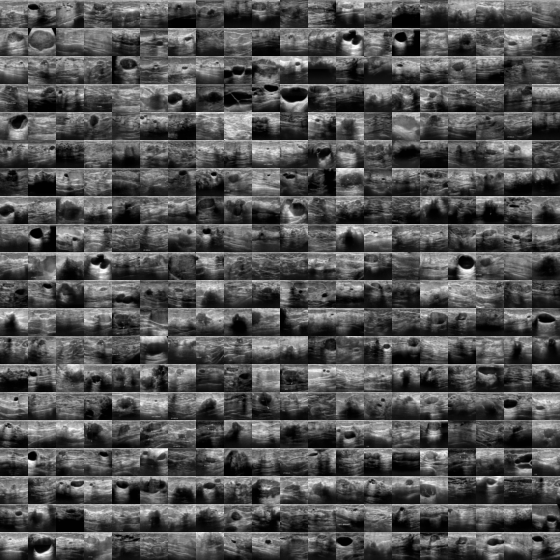

In [8]:
train_data.montage()

evaluation function

In [8]:
def evaluate(dataloader):
    model.eval()
    correct = 0
    total = 0
    auc_score = 0.0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Calculate AUC score (assuming binary classification)
            targets = targets.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()[:, 1]  # Get scores for the positive class
            auc_score += roc_auc_score(targets, outputs)

    acc = correct / total
    auc_score /= len(dataloader)

    return auc_score, acc


# DAM

In [9]:
# Define the model
model = models.resnet18(pretrained=False, num_classes=n_classes)
model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

## Resnet18

In [12]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

100%|██████████| 9/9 [00:03<00:00,  2.43it/s]


==> Evaluating after epoch 1 ...
Train AUC: 0.5411189664762444, Train ACC: 45.56043956043956
Test AUC: 0.47489576475751594, Test ACC: 80.07692307692308
==> Best test AUC and ACC score updated: 0.4749, 80.0769


100%|██████████| 9/9 [00:00<00:00, 28.61it/s]


==> Evaluating after epoch 2 ...
Train AUC: 0.6872340195841999, Train ACC: 42.65201465201465
Test AUC: 0.6496818082071538, Test ACC: 75.43589743589743
==> Best test AUC and ACC score updated: 0.6497, 75.4359


100%|██████████| 9/9 [00:00<00:00, 29.49it/s]


==> Evaluating after epoch 3 ...
Train AUC: 0.646116668388944, Train ACC: 43.142857142857146
Test AUC: 0.6509106868553873, Test ACC: 77.75641025641026
==> Best test AUC and ACC score updated: 0.6509, 77.7564


100%|██████████| 9/9 [00:00<00:00, 29.39it/s]


==> Evaluating after epoch 4 ...
Train AUC: 0.7772844298707713, Train ACC: 39.63003663003663
Test AUC: 0.756111476848804, Test ACC: 71.53846153846153
==> Best test AUC and ACC score updated: 0.7561, 71.5385


100%|██████████| 9/9 [00:00<00:00, 29.16it/s]


==> Evaluating after epoch 5 ...
Train AUC: 0.7538314926873669, Train ACC: 40.51282051282051
Test AUC: 0.6730963353083168, Test ACC: 68.1923076923077


100%|██████████| 9/9 [00:00<00:00, 29.60it/s]


==> Evaluating after epoch 6 ...
Train AUC: 0.7586920798286356, Train ACC: 40.89010989010989
Test AUC: 0.693504498573623, Test ACC: 73.2051282051282


100%|██████████| 9/9 [00:00<00:00, 28.98it/s]


==> Evaluating after epoch 7 ...
Train AUC: 0.7880932692344846, Train ACC: 39.92673992673993
Test AUC: 0.7012508229098091, Test ACC: 71.53846153846153


100%|██████████| 9/9 [00:00<00:00, 29.31it/s]


==> Evaluating after epoch 8 ...
Train AUC: 0.8201393349673733, Train ACC: 40.59340659340659
Test AUC: 0.7155804257186746, Test ACC: 71.53846153846153


100%|██████████| 9/9 [00:00<00:00, 29.41it/s]


==> Evaluating after epoch 9 ...
Train AUC: 0.823890034917382, Train ACC: 41.15018315018315
Test AUC: 0.5980908492429229, Test ACC: 73.75641025641026


100%|██████████| 9/9 [00:00<00:00, 29.27it/s]


==> Evaluating after epoch 10 ...
Train AUC: 0.8418788613191313, Train ACC: 41.6996336996337
Test AUC: 0.6771560236998024, Test ACC: 74.78205128205128


100%|██████████| 9/9 [00:00<00:00, 27.88it/s]


==> Evaluating after epoch 11 ...
Train AUC: 0.8682770551986833, Train ACC: 40.146520146520146
Test AUC: 0.6723063418915953, Test ACC: 71.71794871794872


100%|██████████| 9/9 [00:00<00:00, 29.61it/s]


==> Evaluating after epoch 12 ...
Train AUC: 0.8586996797925338, Train ACC: 40.9010989010989
Test AUC: 0.7009436032477507, Test ACC: 72.08974358974359


100%|██████████| 9/9 [00:00<00:00, 29.31it/s]


==> Evaluating after epoch 13 ...
Train AUC: 0.8249627964222114, Train ACC: 41.252747252747255
Test AUC: 0.7045863506693, Test ACC: 71.25641025641026


100%|██████████| 9/9 [00:00<00:00, 28.70it/s]


==> Evaluating after epoch 14 ...
Train AUC: 0.8889852435900969, Train ACC: 39.446886446886445
Test AUC: 0.6444371296905859, Test ACC: 71.35897435897436


100%|██████████| 9/9 [00:00<00:00, 29.26it/s]


==> Evaluating after epoch 15 ...
Train AUC: 0.8618070625367442, Train ACC: 41.31868131868132
Test AUC: 0.6613342111037963, Test ACC: 75.34615384615384


100%|██████████| 9/9 [00:00<00:00, 28.29it/s]


==> Evaluating after epoch 16 ...
Train AUC: 0.8724085814335546, Train ACC: 39.45421245421245
Test AUC: 0.6607636603028308, Test ACC: 69.21794871794872


100%|██████████| 9/9 [00:00<00:00, 28.05it/s]


==> Evaluating after epoch 17 ...
Train AUC: 0.8665672337972534, Train ACC: 40.586080586080584
Test AUC: 0.7770024138687732, Test ACC: 72.28205128205128
==> Best test AUC and ACC score updated: 0.7770, 72.2821


100%|██████████| 9/9 [00:00<00:00, 27.31it/s]


==> Evaluating after epoch 18 ...
Train AUC: 0.8939515067766093, Train ACC: 37.89010989010989
Test AUC: 0.7105551898178626, Test ACC: 65.87179487179488


100%|██████████| 9/9 [00:00<00:00, 28.86it/s]


==> Evaluating after epoch 19 ...
Train AUC: 0.9309840301411809, Train ACC: 38.37362637362637
Test AUC: 0.7467412771560237, Test ACC: 69.12820512820512


100%|██████████| 9/9 [00:00<00:00, 29.10it/s]


==> Evaluating after epoch 20 ...
Train AUC: 0.9166661290796054, Train ACC: 39.59340659340659
Test AUC: 0.7731182795698925, Test ACC: 70.8076923076923


100%|██████████| 9/9 [00:00<00:00, 28.81it/s]


==> Evaluating after epoch 21 ...
Train AUC: 0.9147667078171217, Train ACC: 40.285714285714285
Test AUC: 0.8260039499670836, Test ACC: 71.07692307692308
==> Best test AUC and ACC score updated: 0.8260, 71.0769


100%|██████████| 9/9 [00:00<00:00, 29.21it/s]


==> Evaluating after epoch 22 ...
Train AUC: 0.93369730859021, Train ACC: 40.062271062271066
Test AUC: 0.7281325433399166, Test ACC: 72.74358974358974


100%|██████████| 9/9 [00:00<00:00, 28.56it/s]


==> Evaluating after epoch 23 ...
Train AUC: 0.9426585914899932, Train ACC: 37.73992673992674
Test AUC: 0.7521615097651964, Test ACC: 65.42307692307692


100%|██████████| 9/9 [00:00<00:00, 28.19it/s]


==> Evaluating after epoch 24 ...
Train AUC: 0.9455851866152928, Train ACC: 39.64468864468864
Test AUC: 0.7856045644064078, Test ACC: 68.93589743589743


100%|██████████| 9/9 [00:00<00:00, 28.95it/s]


==> Evaluating after epoch 25 ...
Train AUC: 0.93656767604684, Train ACC: 40.11721611721612
Test AUC: 0.7866140004388851, Test ACC: 72.65384615384616


100%|██████████| 9/9 [00:00<00:00, 25.04it/s]


==> Evaluating after epoch 26 ...
Train AUC: 0.9203214176988295, Train ACC: 39.040293040293044
Test AUC: 0.7728768926925609, Test ACC: 67.92307692307692


100%|██████████| 9/9 [00:00<00:00, 28.35it/s]


==> Evaluating after epoch 27 ...
Train AUC: 0.9190507145862917, Train ACC: 39.223443223443226
Test AUC: 0.8296466973886328, Test ACC: 68.38461538461539
==> Best test AUC and ACC score updated: 0.8296, 68.3846


100%|██████████| 9/9 [00:00<00:00, 29.32it/s]


==> Evaluating after epoch 28 ...
Train AUC: 0.9431256443614132, Train ACC: 37.747252747252745
Test AUC: 0.7154048716260698, Test ACC: 68.2948717948718


100%|██████████| 9/9 [00:00<00:00, 29.30it/s]


==> Evaluating after epoch 29 ...
Train AUC: 0.9345966997561939, Train ACC: 39.72527472527472
Test AUC: 0.7458196181698487, Test ACC: 72.1025641025641


100%|██████████| 9/9 [00:00<00:00, 29.26it/s]


==> Evaluating after epoch 30 ...
Train AUC: 0.9353078555476569, Train ACC: 38.11355311355312
Test AUC: 0.6964889181479044, Test ACC: 66.71794871794872


100%|██████████| 9/9 [00:00<00:00, 29.01it/s]


==> Evaluating after epoch 31 ...
Train AUC: 0.960529179913248, Train ACC: 38.8974358974359
Test AUC: 0.7338599956111477, Test ACC: 70.42307692307692


100%|██████████| 9/9 [00:00<00:00, 28.79it/s]


==> Evaluating after epoch 32 ...
Train AUC: 0.9398911358958715, Train ACC: 38.24175824175824
Test AUC: 0.687557603686636, Test ACC: 71.35897435897436


100%|██████████| 9/9 [00:00<00:00, 28.80it/s]


==> Evaluating after epoch 33 ...
Train AUC: 0.9589272212290878, Train ACC: 37.97069597069597
Test AUC: 0.7318630678077682, Test ACC: 69.6923076923077


100%|██████████| 9/9 [00:00<00:00, 28.99it/s]


==> Evaluating after epoch 34 ...
Train AUC: 0.966244847792247, Train ACC: 36.875457875457876
Test AUC: 0.7748079877112135, Test ACC: 65.14102564102564


100%|██████████| 9/9 [00:00<00:00, 28.38it/s]


==> Evaluating after epoch 35 ...
Train AUC: 0.9635897159240803, Train ACC: 38.56410256410256
Test AUC: 0.683080974325214, Test ACC: 69.03846153846153


100%|██████████| 9/9 [00:00<00:00, 29.02it/s]


==> Evaluating after epoch 36 ...
Train AUC: 0.9568261318849502, Train ACC: 39.12820512820513
Test AUC: 0.7275839368005267, Test ACC: 70.98717948717949


100%|██████████| 9/9 [00:00<00:00, 28.79it/s]


==> Evaluating after epoch 37 ...
Train AUC: 0.9639160340370884, Train ACC: 37.84981684981685
Test AUC: 0.8346499890278691, Test ACC: 68.48717948717949
==> Best test AUC and ACC score updated: 0.8346, 68.4872


100%|██████████| 9/9 [00:00<00:00, 29.28it/s]


==> Evaluating after epoch 38 ...
Train AUC: 0.9642987857669887, Train ACC: 38.64468864468864
Test AUC: 0.7754882598200571, Test ACC: 69.78205128205128


100%|██████████| 9/9 [00:00<00:00, 28.69it/s]


==> Evaluating after epoch 39 ...
Train AUC: 0.9656454716343971, Train ACC: 38.37728937728938
Test AUC: 0.771999122229537, Test ACC: 70.7051282051282


100%|██████████| 9/9 [00:00<00:00, 28.43it/s]


==> Evaluating after epoch 40 ...
Train AUC: 0.9587026828132507, Train ACC: 39.13186813186813
Test AUC: 0.7195742813254334, Test ACC: 70.88461538461539


100%|██████████| 9/9 [00:00<00:00, 28.24it/s]


==> Evaluating after epoch 41 ...
Train AUC: 0.9683506646185417, Train ACC: 38.24175824175824
Test AUC: 0.8375685758174237, Test ACC: 70.24358974358974
==> Best test AUC and ACC score updated: 0.8376, 70.2436


100%|██████████| 9/9 [00:00<00:00, 26.38it/s]


==> Evaluating after epoch 42 ...
Train AUC: 0.9668606293526941, Train ACC: 38.76190476190476
Test AUC: 0.8067368883037086, Test ACC: 67.55128205128206


100%|██████████| 9/9 [00:00<00:00, 28.00it/s]


==> Evaluating after epoch 43 ...
Train AUC: 0.9748007774808014, Train ACC: 38.095238095238095
Test AUC: 0.7880403774412991, Test ACC: 69.58974358974359


100%|██████████| 9/9 [00:00<00:00, 28.72it/s]


==> Evaluating after epoch 44 ...
Train AUC: 0.970223536558389, Train ACC: 37.76923076923077
Test AUC: 0.7331797235023041, Test ACC: 66.8076923076923


100%|██████████| 9/9 [00:00<00:00, 28.99it/s]


==> Evaluating after epoch 45 ...
Train AUC: 0.968232193201188, Train ACC: 39.42124542124542
Test AUC: 0.7245995172262454, Test ACC: 68.84615384615384


100%|██████████| 9/9 [00:00<00:00, 28.77it/s]


==> Evaluating after epoch 46 ...
Train AUC: 0.97120512187878, Train ACC: 37.61538461538461
Test AUC: 0.747816545973228, Test ACC: 67.55128205128206


100%|██████████| 9/9 [00:00<00:00, 29.72it/s]


==> Evaluating after epoch 47 ...
Train AUC: 0.9648408497201445, Train ACC: 38.86446886446886
Test AUC: 0.75229317533465, Test ACC: 71.07692307692308


100%|██████████| 9/9 [00:00<00:00, 29.10it/s]


==> Evaluating after epoch 48 ...
Train AUC: 0.9789566280132357, Train ACC: 38.553113553113555
Test AUC: 0.7971253017335966, Test ACC: 68.66666666666667


100%|██████████| 9/9 [00:00<00:00, 28.56it/s]


==> Evaluating after epoch 49 ...
Train AUC: 0.9556787314685172, Train ACC: 38.05860805860806
Test AUC: 0.7182795698924731, Test ACC: 68.38461538461539


100%|██████████| 9/9 [00:00<00:00, 28.29it/s]


==> Evaluating after epoch 50 ...
Train AUC: 0.9837777386484051, Train ACC: 38.35164835164835
Test AUC: 0.7477507131885012, Test ACC: 69.12820512820512


100%|██████████| 9/9 [00:00<00:00, 28.21it/s]


==> Evaluating after epoch 51 ...
Train AUC: 0.9753108328563831, Train ACC: 37.3992673992674
Test AUC: 0.7491990344524906, Test ACC: 69.12820512820512


100%|██████████| 9/9 [00:00<00:00, 28.90it/s]


==> Evaluating after epoch 52 ...
Train AUC: 0.9853928948171418, Train ACC: 37.92307692307692
Test AUC: 0.6651744568795259, Test ACC: 67.35897435897436


100%|██████████| 9/9 [00:00<00:00, 29.31it/s]


==> Evaluating after epoch 53 ...
Train AUC: 0.9823615088490393, Train ACC: 37.78388278388278
Test AUC: 0.7746543778801843, Test ACC: 67.92307692307692


100%|██████████| 9/9 [00:00<00:00, 29.32it/s]


==> Evaluating after epoch 54 ...
Train AUC: 0.9867826225252985, Train ACC: 39.311355311355314
Test AUC: 0.7951064296686416, Test ACC: 69.12820512820512


100%|██████████| 9/9 [00:00<00:00, 29.09it/s]


==> Evaluating after epoch 55 ...
Train AUC: 0.9880720720903131, Train ACC: 37.68131868131868
Test AUC: 0.7898178626289225, Test ACC: 66.98717948717949


100%|██████████| 9/9 [00:00<00:00, 28.84it/s]


==> Evaluating after epoch 56 ...
Train AUC: 0.9762306202744551, Train ACC: 38.41025641025641
Test AUC: 0.7111257406188282, Test ACC: 70.33333333333333


100%|██████████| 9/9 [00:00<00:00, 29.10it/s]


==> Evaluating after epoch 57 ...
Train AUC: 0.9896219542405489, Train ACC: 38.73992673992674
Test AUC: 0.7946017116524029, Test ACC: 69.03846153846153


100%|██████████| 9/9 [00:00<00:00, 27.51it/s]


==> Evaluating after epoch 58 ...
Train AUC: 0.9864278169008802, Train ACC: 38.32600732600733
Test AUC: 0.7686197059468949, Test ACC: 67.55128205128206


100%|██████████| 9/9 [00:00<00:00, 29.16it/s]


==> Evaluating after epoch 59 ...
Train AUC: 0.9900091154981716, Train ACC: 38.505494505494504
Test AUC: 0.7554092604783849, Test ACC: 69.41025641025641


100%|██████████| 9/9 [00:00<00:00, 28.50it/s]


==> Evaluating after epoch 60 ...
Train AUC: 0.9764934221655209, Train ACC: 37.65934065934066
Test AUC: 0.7877331577792408, Test ACC: 66.34615384615384


100%|██████████| 9/9 [00:00<00:00, 29.26it/s]


==> Evaluating after epoch 61 ...
Train AUC: 0.9775832448962576, Train ACC: 38.446886446886445
Test AUC: 0.7335966644722405, Test ACC: 67.73076923076923


100%|██████████| 9/9 [00:00<00:00, 28.97it/s]


==> Evaluating after epoch 62 ...
Train AUC: 0.9895061698272056, Train ACC: 38.1978021978022
Test AUC: 0.7937458854509545, Test ACC: 67.64102564102564


100%|██████████| 9/9 [00:00<00:00, 28.73it/s]


==> Evaluating after epoch 63 ...
Train AUC: 0.9829892012913852, Train ACC: 38.15018315018315
Test AUC: 0.7486504279131008, Test ACC: 68.1025641025641


100%|██████████| 9/9 [00:00<00:00, 29.27it/s]


==> Evaluating after epoch 64 ...
Train AUC: 0.9891410222058236, Train ACC: 37.586080586080584
Test AUC: 0.7938336624972571, Test ACC: 66.24358974358974


100%|██████████| 9/9 [00:00<00:00, 28.83it/s]


==> Evaluating after epoch 65 ...
Train AUC: 0.987947572023542, Train ACC: 38.99633699633699
Test AUC: 0.804366908053544, Test ACC: 70.15384615384616


100%|██████████| 9/9 [00:00<00:00, 28.22it/s]


==> Evaluating after epoch 66 ...
Train AUC: 0.9728466125227793, Train ACC: 37.56043956043956
Test AUC: 0.838424402018872, Test ACC: 64.48717948717949
==> Best test AUC and ACC score updated: 0.8384, 64.4872


100%|██████████| 9/9 [00:00<00:00, 27.48it/s]


==> Evaluating after epoch 67 ...
Train AUC: 0.9841180949717327, Train ACC: 38.24908424908425
Test AUC: 0.7976958525345622, Test ACC: 69.58974358974359


100%|██████████| 9/9 [00:00<00:00, 28.06it/s]


==> Evaluating after epoch 68 ...
Train AUC: 0.9928929316323664, Train ACC: 38.24175824175824
Test AUC: 0.7443274083827078, Test ACC: 68.48717948717949


100%|██████████| 9/9 [00:00<00:00, 26.65it/s]


==> Evaluating after epoch 69 ...
Train AUC: 0.9852727526830933, Train ACC: 39.02564102564103
Test AUC: 0.7815448760149221, Test ACC: 70.24358974358974


100%|██████████| 9/9 [00:00<00:00, 29.39it/s]


==> Evaluating after epoch 70 ...
Train AUC: 0.9830079937331081, Train ACC: 37.84981684981685
Test AUC: 0.7701338599956111, Test ACC: 67.83333333333333


100%|██████████| 9/9 [00:00<00:00, 28.01it/s]


==> Evaluating after epoch 71 ...
Train AUC: 0.9875764549142428, Train ACC: 38.73626373626374
Test AUC: 0.760697827518104, Test ACC: 69.12820512820512


100%|██████████| 9/9 [00:00<00:00, 29.17it/s]


==> Evaluating after epoch 72 ...
Train AUC: 0.9901526360518389, Train ACC: 38.30769230769231
Test AUC: 0.8065832784726794, Test ACC: 69.87179487179488


100%|██████████| 9/9 [00:00<00:00, 28.81it/s]


==> Evaluating after epoch 73 ...
Train AUC: 0.9901742831280242, Train ACC: 38.30769230769231
Test AUC: 0.8103796357252578, Test ACC: 68.01282051282051


100%|██████████| 9/9 [00:00<00:00, 28.93it/s]


==> Evaluating after epoch 74 ...
Train AUC: 0.9902866647430416, Train ACC: 38.205128205128204
Test AUC: 0.8488918147904323, Test ACC: 66.98717948717949
==> Best test AUC and ACC score updated: 0.8489, 66.9872


100%|██████████| 9/9 [00:00<00:00, 28.05it/s]


==> Evaluating after epoch 75 ...
Train AUC: 0.9887352556533229, Train ACC: 38.717948717948715
Test AUC: 0.7785385121790651, Test ACC: 70.7051282051282


100%|██████████| 9/9 [00:00<00:00, 28.90it/s]


==> Evaluating after epoch 76 ...
Train AUC: 0.9923417290534869, Train ACC: 38.69597069597069
Test AUC: 0.8212639894667545, Test ACC: 70.52564102564102


100%|██████████| 9/9 [00:00<00:00, 28.65it/s]


==> Evaluating after epoch 77 ...
Train AUC: 0.9881986763245152, Train ACC: 37.59340659340659
Test AUC: 0.8237217467632214, Test ACC: 67.92307692307692


100%|██████████| 9/9 [00:00<00:00, 29.37it/s]


==> Evaluating after epoch 78 ...
Train AUC: 0.991434002310288, Train ACC: 37.476190476190474
Test AUC: 0.7820495940311608, Test ACC: 65.03846153846153


100%|██████████| 9/9 [00:00<00:00, 28.69it/s]


==> Evaluating after epoch 79 ...
Train AUC: 0.9939835563263392, Train ACC: 38.00366300366301
Test AUC: 0.782532367785824, Test ACC: 70.24358974358974


100%|██████████| 9/9 [00:00<00:00, 27.72it/s]


==> Evaluating after epoch 80 ...
Train AUC: 0.9928788326043652, Train ACC: 37.937728937728934
Test AUC: 0.8141759929778363, Test ACC: 64.67948717948718


100%|██████████| 9/9 [00:00<00:00, 28.62it/s]


==> Evaluating after epoch 81 ...
Train AUC: 0.9959942397578266, Train ACC: 37.94505494505494
Test AUC: 0.7660961158657011, Test ACC: 67.35897435897436


100%|██████████| 9/9 [00:00<00:00, 28.92it/s]


==> Evaluating after epoch 82 ...
Train AUC: 0.992505688415997, Train ACC: 38.4029304029304
Test AUC: 0.7749177090190915, Test ACC: 68.01282051282051


100%|██████████| 9/9 [00:00<00:00, 28.26it/s]


==> Evaluating after epoch 83 ...
Train AUC: 0.9909270102525378, Train ACC: 38.30769230769231
Test AUC: 0.7817862628922536, Test ACC: 70.7051282051282


100%|██████████| 9/9 [00:00<00:00, 29.11it/s]


==> Evaluating after epoch 84 ...
Train AUC: 0.9877775059954959, Train ACC: 37.31868131868132
Test AUC: 0.7626508667983323, Test ACC: 66.44871794871794


100%|██████████| 9/9 [00:00<00:00, 29.04it/s]


==> Evaluating after epoch 85 ...
Train AUC: 0.9863927857803808, Train ACC: 38.8058608058608
Test AUC: 0.7768488040377441, Test ACC: 70.98717948717949


100%|██████████| 9/9 [00:00<00:00, 27.95it/s]


==> Evaluating after epoch 86 ...
Train AUC: 0.9858491514638636, Train ACC: 37.70695970695971
Test AUC: 0.8171604125521177, Test ACC: 68.47435897435898


100%|██████████| 9/9 [00:00<00:00, 28.20it/s]


==> Evaluating after epoch 87 ...
Train AUC: 0.9934611279707437, Train ACC: 39.19047619047619
Test AUC: 0.82128593372833, Test ACC: 70.33333333333333


100%|██████████| 9/9 [00:00<00:00, 28.68it/s]


==> Evaluating after epoch 88 ...
Train AUC: 0.9899421458511107, Train ACC: 38.853479853479854
Test AUC: 0.8201887206495502, Test ACC: 69.96153846153847


100%|██████████| 9/9 [00:00<00:00, 28.99it/s]


==> Evaluating after epoch 89 ...
Train AUC: 0.9955293388863827, Train ACC: 37.91208791208791
Test AUC: 0.883519859556726, Test ACC: 67.73076923076923
==> Best test AUC and ACC score updated: 0.8835, 67.7308


100%|██████████| 9/9 [00:00<00:00, 27.78it/s]


==> Evaluating after epoch 90 ...
Train AUC: 0.9945821825678856, Train ACC: 37.73992673992674
Test AUC: 0.8258064516129032, Test ACC: 68.01282051282051


100%|██████████| 9/9 [00:00<00:00, 28.28it/s]


==> Evaluating after epoch 91 ...
Train AUC: 0.9969649981921952, Train ACC: 37.98168498168498
Test AUC: 0.8487601492209786, Test ACC: 68.75641025641026


100%|██████████| 9/9 [00:00<00:00, 26.81it/s]


==> Evaluating after epoch 92 ...
Train AUC: 0.9927711690559681, Train ACC: 37.6996336996337
Test AUC: 0.7479043230195304, Test ACC: 66.06410256410257


100%|██████████| 9/9 [00:00<00:00, 28.21it/s]


==> Evaluating after epoch 93 ...
Train AUC: 0.9980207902038892, Train ACC: 38.05494505494506
Test AUC: 0.8130787798990564, Test ACC: 68.38461538461539


100%|██████████| 9/9 [00:00<00:00, 28.51it/s]


==> Evaluating after epoch 94 ...
Train AUC: 0.995183741392623, Train ACC: 38.12820512820513
Test AUC: 0.8092824226464779, Test ACC: 66.52564102564102


100%|██████████| 9/9 [00:00<00:00, 28.57it/s]


==> Evaluating after epoch 95 ...
Train AUC: 0.9919705975997269, Train ACC: 38.41025641025641
Test AUC: 0.7975202984419574, Test ACC: 67.83333333333333


100%|██████████| 9/9 [00:00<00:00, 28.79it/s]


==> Evaluating after epoch 96 ...
Train AUC: 0.991769902574523, Train ACC: 37.47985347985348
Test AUC: 0.7973008558262015, Test ACC: 65.32051282051282


100%|██████████| 9/9 [00:00<00:00, 27.82it/s]


==> Evaluating after epoch 97 ...
Train AUC: 0.9963678637876764, Train ACC: 38.282051282051285
Test AUC: 0.8318630678077683, Test ACC: 70.98717948717949


100%|██████████| 9/9 [00:00<00:00, 29.09it/s]


==> Evaluating after epoch 98 ...
Train AUC: 0.9913545218676619, Train ACC: 38.20879120879121
Test AUC: 0.7959842001316656, Test ACC: 67.26923076923077


100%|██████████| 9/9 [00:00<00:00, 28.49it/s]


==> Evaluating after epoch 99 ...
Train AUC: 0.9934243046995456, Train ACC: 38.32600732600733
Test AUC: 0.7074391046741277, Test ACC: 69.96153846153847


100%|██████████| 9/9 [00:00<00:00, 29.16it/s]


==> Evaluating after epoch 100 ...
Train AUC: 0.9951794528547002, Train ACC: 37.67765567765568
Test AUC: 0.83853412332675, Test ACC: 66.06410256410257


100%|██████████| 9/9 [00:00<00:00, 28.26it/s]


==> Evaluating after epoch 101 ...
Train AUC: 0.9922499126972676, Train ACC: 38.26373626373626
Test AUC: 0.7886548167654158, Test ACC: 67.55128205128206


100%|██████████| 9/9 [00:00<00:00, 28.08it/s]


==> Evaluating after epoch 102 ...
Train AUC: 0.9971501052492103, Train ACC: 38.13553113553114
Test AUC: 0.7664691683124865, Test ACC: 70.7051282051282


100%|██████████| 9/9 [00:00<00:00, 28.71it/s]


==> Evaluating after epoch 103 ...
Train AUC: 0.9948667886035251, Train ACC: 37.53113553113553
Test AUC: 0.7978055738424403, Test ACC: 66.15384615384616


100%|██████████| 9/9 [00:00<00:00, 28.25it/s]


==> Evaluating after epoch 104 ...
Train AUC: 0.9924971862373594, Train ACC: 38.68131868131868
Test AUC: 0.8129032258064517, Test ACC: 67.73076923076923


100%|██████████| 9/9 [00:00<00:00, 28.63it/s]


==> Evaluating after epoch 105 ...
Train AUC: 0.9944201936639723, Train ACC: 38.83150183150183
Test AUC: 0.7420452051788458, Test ACC: 71.07692307692308


100%|██████████| 9/9 [00:00<00:00, 28.17it/s]


==> Evaluating after epoch 106 ...
Train AUC: 0.9973914306189123, Train ACC: 38.417582417582416
Test AUC: 0.787777046302392, Test ACC: 70.71794871794872


100%|██████████| 9/9 [00:00<00:00, 28.94it/s]


==> Evaluating after epoch 107 ...
Train AUC: 0.999458122895623, Train ACC: 38.69230769230769
Test AUC: 0.7760807548825982, Test ACC: 69.41025641025641


100%|██████████| 9/9 [00:00<00:00, 28.58it/s]


==> Evaluating after epoch 108 ...
Train AUC: 0.9985304627790134, Train ACC: 37.81318681318681
Test AUC: 0.8454246214614878, Test ACC: 64.94871794871794


100%|██████████| 9/9 [00:00<00:00, 28.49it/s]


==> Evaluating after epoch 109 ...
Train AUC: 0.999546485260771, Train ACC: 38.175824175824175
Test AUC: 0.7886328725038403, Test ACC: 68.85897435897436


100%|██████████| 9/9 [00:00<00:00, 28.07it/s]


==> Evaluating after epoch 110 ...
Train AUC: 0.9964109891266428, Train ACC: 37.9010989010989
Test AUC: 0.7631116962914197, Test ACC: 72.1923076923077


100%|██████████| 9/9 [00:00<00:00, 28.42it/s]


==> Evaluating after epoch 111 ...
Train AUC: 0.9930485671065381, Train ACC: 37.95238095238095
Test AUC: 0.723633969716919, Test ACC: 68.47435897435898


100%|██████████| 9/9 [00:00<00:00, 29.30it/s]


==> Evaluating after epoch 112 ...
Train AUC: 0.9975039821078151, Train ACC: 37.967032967032964
Test AUC: 0.8174895764757515, Test ACC: 66.15384615384616


100%|██████████| 9/9 [00:00<00:00, 28.53it/s]


==> Evaluating after epoch 113 ...
Train AUC: 0.9975638568387003, Train ACC: 38.172161172161175
Test AUC: 0.8121132323897302, Test ACC: 69.58974358974359


100%|██████████| 9/9 [00:00<00:00, 28.97it/s]


==> Evaluating after epoch 114 ...
Train AUC: 0.995670948639503, Train ACC: 38.23809523809524
Test AUC: 0.8111476848804038, Test ACC: 69.87179487179488


100%|██████████| 9/9 [00:00<00:00, 25.85it/s]


==> Evaluating after epoch 115 ...
Train AUC: 0.9960301907394931, Train ACC: 37.772893772893774
Test AUC: 0.8230853631775291, Test ACC: 67.55128205128206


100%|██████████| 9/9 [00:00<00:00, 28.00it/s]


==> Evaluating after epoch 116 ...
Train AUC: 0.9940275510778803, Train ACC: 38.24908424908425
Test AUC: 0.7966644722405091, Test ACC: 68.84615384615384


100%|██████████| 9/9 [00:00<00:00, 27.98it/s]


==> Evaluating after epoch 117 ...
Train AUC: 0.9972625471622965, Train ACC: 38.64102564102564
Test AUC: 0.8217687074829932, Test ACC: 69.87179487179488


100%|██████████| 9/9 [00:00<00:00, 27.55it/s]


==> Evaluating after epoch 118 ...
Train AUC: 0.9949170123588728, Train ACC: 37.663003663003664
Test AUC: 0.8276058810621023, Test ACC: 65.97435897435898


100%|██████████| 9/9 [00:00<00:00, 29.13it/s]


==> Evaluating after epoch 119 ...
Train AUC: 0.9976896134463116, Train ACC: 37.75091575091575
Test AUC: 0.7840026333113891, Test ACC: 66.34615384615384


100%|██████████| 9/9 [00:00<00:00, 29.24it/s]


==> Evaluating after epoch 120 ...
Train AUC: 0.9974812727352409, Train ACC: 37.94139194139194
Test AUC: 0.814680710994075, Test ACC: 69.6923076923077


100%|██████████| 9/9 [00:00<00:00, 28.74it/s]


==> Evaluating after epoch 121 ...
Train AUC: 0.9981378475760658, Train ACC: 38.27106227106227
Test AUC: 0.7912881281544876, Test ACC: 69.3076923076923


100%|██████████| 9/9 [00:00<00:00, 27.51it/s]


==> Evaluating after epoch 122 ...
Train AUC: 0.9876785490088302, Train ACC: 38.15384615384615
Test AUC: 0.7843537414965986, Test ACC: 67.92307692307692


100%|██████████| 9/9 [00:00<00:00, 28.94it/s]


==> Evaluating after epoch 123 ...
Train AUC: 0.9961312271905164, Train ACC: 38.75457875457875
Test AUC: 0.7586131226684222, Test ACC: 69.02564102564102


100%|██████████| 9/9 [00:00<00:00, 29.17it/s]


==> Evaluating after epoch 124 ...
Train AUC: 0.9959056505578611, Train ACC: 37.717948717948715
Test AUC: 0.8032477507131885, Test ACC: 67.17948717948718


100%|██████████| 9/9 [00:00<00:00, 29.02it/s]


==> Evaluating after epoch 125 ...
Train AUC: 0.9979482611764051, Train ACC: 38.18681318681319
Test AUC: 0.7895984200131665, Test ACC: 66.71794871794872


100%|██████████| 9/9 [00:00<00:00, 28.85it/s]


==> Evaluating after epoch 126 ...
Train AUC: 0.9984590836925786, Train ACC: 38.333333333333336
Test AUC: 0.7798990563967523, Test ACC: 69.96153846153847


100%|██████████| 9/9 [00:00<00:00, 28.57it/s]


==> Evaluating after epoch 127 ...
Train AUC: 0.9962934832024553, Train ACC: 37.666666666666664
Test AUC: 0.8206934386657888, Test ACC: 71.44871794871794


100%|██████████| 9/9 [00:00<00:00, 28.71it/s]


==> Evaluating after epoch 128 ...
Train AUC: 0.9961615078010573, Train ACC: 38.19047619047619
Test AUC: 0.8059688391485627, Test ACC: 68.94871794871794


100%|██████████| 9/9 [00:00<00:00, 28.43it/s]


==> Evaluating after epoch 129 ...
Train AUC: 0.9952488653296798, Train ACC: 38.1025641025641
Test AUC: 0.8117182356813692, Test ACC: 71.73076923076923


100%|██████████| 9/9 [00:00<00:00, 28.87it/s]


==> Evaluating after epoch 130 ...
Train AUC: 0.9966339993663225, Train ACC: 38.42124542124542
Test AUC: 0.8455123985077901, Test ACC: 68.56410256410257


100%|██████████| 9/9 [00:00<00:00, 28.92it/s]


==> Evaluating after epoch 131 ...
Train AUC: 0.9969772517336012, Train ACC: 38.46520146520147
Test AUC: 0.7861092824226465, Test ACC: 68.38461538461539


100%|██████████| 9/9 [00:00<00:00, 28.18it/s]


==> Evaluating after epoch 132 ...
Train AUC: 0.9957388581651306, Train ACC: 38.82051282051282
Test AUC: 0.8293614219881501, Test ACC: 69.12820512820512


100%|██████████| 9/9 [00:00<00:00, 27.67it/s]


==> Evaluating after epoch 133 ...
Train AUC: 0.9977517947826955, Train ACC: 38.08058608058608
Test AUC: 0.8166556945358789, Test ACC: 69.96153846153847


100%|██████████| 9/9 [00:00<00:00, 27.09it/s]


==> Evaluating after epoch 134 ...
Train AUC: 0.9960248326661088, Train ACC: 37.93040293040293
Test AUC: 0.8007241606319948, Test ACC: 66.8076923076923


100%|██████████| 9/9 [00:00<00:00, 26.36it/s]


==> Evaluating after epoch 135 ...
Train AUC: 0.9943887828966473, Train ACC: 37.76923076923077
Test AUC: 0.8420013166556946, Test ACC: 68.01282051282051


100%|██████████| 9/9 [00:00<00:00, 22.25it/s]


==> Evaluating after epoch 136 ...
Train AUC: 0.9986776346610904, Train ACC: 37.853479853479854
Test AUC: 0.8219881500987491, Test ACC: 68.84615384615384


100%|██████████| 9/9 [00:00<00:00, 27.10it/s]


==> Evaluating after epoch 137 ...
Train AUC: 0.9966585890073097, Train ACC: 38.523809523809526
Test AUC: 0.840552995391705, Test ACC: 70.33333333333333


100%|██████████| 9/9 [00:00<00:00, 27.66it/s]


==> Evaluating after epoch 138 ...
Train AUC: 0.9915820333207529, Train ACC: 37.57509157509158
Test AUC: 0.7531928900592495, Test ACC: 65.88461538461539


100%|██████████| 9/9 [00:00<00:00, 27.95it/s]


==> Evaluating after epoch 139 ...
Train AUC: 0.9982024624714685, Train ACC: 38.16849816849817
Test AUC: 0.781983761246434, Test ACC: 68.1923076923077


100%|██████████| 9/9 [00:00<00:00, 26.93it/s]


==> Evaluating after epoch 140 ...
Train AUC: 0.9977510208667222, Train ACC: 38.05860805860806
Test AUC: 0.8112354619267061, Test ACC: 67.83333333333333


100%|██████████| 9/9 [00:00<00:00, 26.58it/s]


==> Evaluating after epoch 141 ...
Train AUC: 0.9989603638726448, Train ACC: 38.18681318681319
Test AUC: 0.7949967083607636, Test ACC: 70.33333333333333


100%|██████████| 9/9 [00:00<00:00, 23.92it/s]


==> Evaluating after epoch 142 ...
Train AUC: 0.9988389772694882, Train ACC: 37.91941391941392
Test AUC: 0.835483870967742, Test ACC: 68.2948717948718


100%|██████████| 9/9 [00:00<00:00, 25.57it/s]


==> Evaluating after epoch 143 ...
Train AUC: 0.9969307055036667, Train ACC: 37.96336996336996
Test AUC: 0.8511740179942945, Test ACC: 68.47435897435898


100%|██████████| 9/9 [00:00<00:00, 25.44it/s]


==> Evaluating after epoch 144 ...
Train AUC: 0.9940736824700641, Train ACC: 38.40659340659341
Test AUC: 0.8441299100285276, Test ACC: 69.87179487179488


100%|██████████| 9/9 [00:00<00:00, 24.58it/s]


==> Evaluating after epoch 145 ...
Train AUC: 0.9988875549882348, Train ACC: 38.27106227106227
Test AUC: 0.821505376344086, Test ACC: 69.87179487179488


100%|██████████| 9/9 [00:00<00:00, 26.88it/s]


==> Evaluating after epoch 146 ...
Train AUC: 0.9954927020471117, Train ACC: 37.72161172161172
Test AUC: 0.8306341891595348, Test ACC: 68.1923076923077


100%|██████████| 9/9 [00:00<00:00, 25.59it/s]


==> Evaluating after epoch 147 ...
Train AUC: 0.9979354160220298, Train ACC: 37.57142857142857
Test AUC: 0.8269475532148343, Test ACC: 66.43589743589743


100%|██████████| 9/9 [00:00<00:00, 25.24it/s]


==> Evaluating after epoch 148 ...
Train AUC: 0.9991993896503814, Train ACC: 38.010989010989015
Test AUC: 0.7865262233925829, Test ACC: 71.53846153846153


100%|██████████| 9/9 [00:00<00:00, 26.26it/s]


==> Evaluating after epoch 149 ...
Train AUC: 0.9975110387742951, Train ACC: 38.256410256410255
Test AUC: 0.8505815229317535, Test ACC: 68.2948717948718


100%|██████████| 9/9 [00:00<00:00, 24.89it/s]


==> Evaluating after epoch 150 ...
Train AUC: 0.9985298435509706, Train ACC: 38.21978021978022
Test AUC: 0.7834101382488479, Test ACC: 68.47435897435898


100%|██████████| 9/9 [00:00<00:00, 25.33it/s]


==> Evaluating after epoch 151 ...
Train AUC: 0.9964778263139578, Train ACC: 37.83882783882784
Test AUC: 0.8381171823568137, Test ACC: 69.03846153846153


100%|██████████| 9/9 [00:00<00:00, 24.96it/s]


==> Evaluating after epoch 152 ...
Train AUC: 0.998387502740675, Train ACC: 37.875457875457876
Test AUC: 0.8222953697608074, Test ACC: 68.56410256410257


100%|██████████| 9/9 [00:00<00:00, 25.55it/s]


==> Evaluating after epoch 153 ...
Train AUC: 0.9993393947969843, Train ACC: 38.1025641025641
Test AUC: 0.8450735132762783, Test ACC: 69.5


100%|██████████| 9/9 [00:00<00:00, 25.94it/s]


==> Evaluating after epoch 154 ...
Train AUC: 0.9975353742824018, Train ACC: 38.07692307692308
Test AUC: 0.7973008558262015, Test ACC: 68.2948717948718


100%|██████████| 9/9 [00:00<00:00, 26.08it/s]


==> Evaluating after epoch 155 ...
Train AUC: 0.9957517636684303, Train ACC: 38.30402930402931
Test AUC: 0.7379196840026332, Test ACC: 69.58974358974359


100%|██████████| 9/9 [00:00<00:00, 25.59it/s]


==> Evaluating after epoch 156 ...
Train AUC: 0.9977949411424711, Train ACC: 37.714285714285715
Test AUC: 0.8162606978275182, Test ACC: 66.71794871794872


100%|██████████| 9/9 [00:00<00:00, 25.76it/s]


==> Evaluating after epoch 157 ...
Train AUC: 0.996859090095805, Train ACC: 37.88644688644688
Test AUC: 0.8116085143734912, Test ACC: 68.1923076923077


100%|██████████| 9/9 [00:00<00:00, 25.12it/s]


==> Evaluating after epoch 158 ...
Train AUC: 0.9995828118481435, Train ACC: 37.91208791208791
Test AUC: 0.8321044546850999, Test ACC: 70.8076923076923


100%|██████████| 9/9 [00:00<00:00, 28.57it/s]


==> Evaluating after epoch 159 ...
Train AUC: 0.9996736814383872, Train ACC: 37.84981684981685
Test AUC: 0.8263550581522932, Test ACC: 68.01282051282051


100%|██████████| 9/9 [00:00<00:00, 28.26it/s]


==> Evaluating after epoch 160 ...
Train AUC: 0.9980857147330957, Train ACC: 37.91575091575091
Test AUC: 0.8236559139784946, Test ACC: 67.46153846153847


100%|██████████| 9/9 [00:00<00:00, 28.39it/s]


==> Evaluating after epoch 161 ...
Train AUC: 0.9993640431828926, Train ACC: 38.553113553113555
Test AUC: 0.7758613122668422, Test ACC: 69.03846153846153


100%|██████████| 9/9 [00:00<00:00, 27.43it/s]


==> Evaluating after epoch 162 ...
Train AUC: 0.9979820210731343, Train ACC: 38.227106227106226
Test AUC: 0.8059249506254114, Test ACC: 70.42307692307692


100%|██████████| 9/9 [00:00<00:00, 27.43it/s]


==> Evaluating after epoch 163 ...
Train AUC: 0.9980359608512023, Train ACC: 38.256410256410255
Test AUC: 0.8270133859995611, Test ACC: 70.7051282051282


100%|██████████| 9/9 [00:00<00:00, 27.56it/s]


==> Evaluating after epoch 164 ...
Train AUC: 0.9975363599786166, Train ACC: 38.252747252747255
Test AUC: 0.7689927583936801, Test ACC: 66.34615384615384


100%|██████████| 9/9 [00:00<00:00, 26.10it/s]


==> Evaluating after epoch 165 ...
Train AUC: 0.9990691301522728, Train ACC: 37.86446886446886
Test AUC: 0.7668202764976959, Test ACC: 68.75641025641026


100%|██████████| 9/9 [00:00<00:00, 27.83it/s]


==> Evaluating after epoch 166 ...
Train AUC: 0.9981347628540678, Train ACC: 38.34432234432234
Test AUC: 0.8477507131885011, Test ACC: 68.2948717948718


100%|██████████| 9/9 [00:00<00:00, 28.47it/s]


==> Evaluating after epoch 167 ...
Train AUC: 0.9992559523809523, Train ACC: 38.527472527472526
Test AUC: 0.832038621900373, Test ACC: 69.96153846153847


100%|██████████| 9/9 [00:00<00:00, 28.61it/s]


==> Evaluating after epoch 168 ...
Train AUC: 0.9968406986646497, Train ACC: 38.03663003663004
Test AUC: 0.7835198595567259, Test ACC: 68.66666666666667


100%|██████████| 9/9 [00:00<00:00, 28.58it/s]


==> Evaluating after epoch 169 ...
Train AUC: 0.996922191663065, Train ACC: 38.1025641025641
Test AUC: 0.7976958525345623, Test ACC: 66.06410256410257


100%|██████████| 9/9 [00:00<00:00, 28.28it/s]


==> Evaluating after epoch 170 ...
Train AUC: 0.9980714035422226, Train ACC: 37.67032967032967
Test AUC: 0.8328725038402458, Test ACC: 67.37179487179488


100%|██████████| 9/9 [00:00<00:00, 28.15it/s]


==> Evaluating after epoch 171 ...
Train AUC: 0.9980741800266206, Train ACC: 37.83882783882784
Test AUC: 0.7986614000438885, Test ACC: 67.46153846153847


100%|██████████| 9/9 [00:00<00:00, 26.68it/s]


==> Evaluating after epoch 172 ...
Train AUC: 0.9974416081444397, Train ACC: 38.032967032967036
Test AUC: 0.7810401579986834, Test ACC: 68.75641025641026


100%|██████████| 9/9 [00:00<00:00, 27.48it/s]


==> Evaluating after epoch 173 ...
Train AUC: 0.9993744819217834, Train ACC: 37.92307692307692
Test AUC: 0.7962694755321482, Test ACC: 69.96153846153847


100%|██████████| 9/9 [00:00<00:00, 27.91it/s]


==> Evaluating after epoch 174 ...
Train AUC: 1.0, Train ACC: 38.23809523809524
Test AUC: 0.7857362299758613, Test ACC: 70.33333333333333


100%|██████████| 9/9 [00:00<00:00, 28.93it/s]


==> Evaluating after epoch 175 ...
Train AUC: 0.998915338645557, Train ACC: 38.56776556776557
Test AUC: 0.7949308755760368, Test ACC: 69.96153846153847


100%|██████████| 9/9 [00:00<00:00, 28.02it/s]


==> Evaluating after epoch 176 ...
Train AUC: 0.999697656840514, Train ACC: 37.908424908424905
Test AUC: 0.8357252578450736, Test ACC: 68.38461538461539


100%|██████████| 9/9 [00:00<00:00, 29.39it/s]


==> Evaluating after epoch 177 ...
Train AUC: 0.998361330347742, Train ACC: 37.608058608058606
Test AUC: 0.8127057274522712, Test ACC: 68.2948717948718


100%|██████████| 9/9 [00:00<00:00, 29.03it/s]


==> Evaluating after epoch 178 ...
Train AUC: 0.9982677302121746, Train ACC: 38.10989010989011
Test AUC: 0.8291639236339697, Test ACC: 67.73076923076923


100%|██████████| 9/9 [00:00<00:00, 28.51it/s]


==> Evaluating after epoch 179 ...
Train AUC: 0.9979223971214819, Train ACC: 38.05494505494506
Test AUC: 0.8191792846170727, Test ACC: 69.41025641025641


100%|██████████| 9/9 [00:00<00:00, 28.68it/s]


==> Evaluating after epoch 180 ...
Train AUC: 0.9987695336532545, Train ACC: 37.91941391941392
Test AUC: 0.816480140443274, Test ACC: 70.7051282051282


100%|██████████| 9/9 [00:00<00:00, 28.46it/s]


==> Evaluating after epoch 181 ...
Train AUC: 0.9989397828407116, Train ACC: 37.956043956043956
Test AUC: 0.7742154926486724, Test ACC: 69.5


100%|██████████| 9/9 [00:00<00:00, 27.29it/s]


==> Evaluating after epoch 182 ...
Train AUC: 0.9957417707238828, Train ACC: 37.89377289377289
Test AUC: 0.8680272108843538, Test ACC: 68.47435897435898


100%|██████████| 9/9 [00:00<00:00, 27.56it/s]


==> Evaluating after epoch 183 ...
Train AUC: 0.9990292035695114, Train ACC: 37.67399267399267
Test AUC: 0.8016677638797455, Test ACC: 69.87179487179488


100%|██████████| 9/9 [00:00<00:00, 28.20it/s]


==> Evaluating after epoch 184 ...
Train AUC: 0.9988047186817443, Train ACC: 37.84615384615385
Test AUC: 0.7951722624533685, Test ACC: 67.17948717948718


100%|██████████| 9/9 [00:00<00:00, 29.00it/s]


==> Evaluating after epoch 185 ...
Train AUC: 0.9994018093348451, Train ACC: 38.08058608058608
Test AUC: 0.8117840684660962, Test ACC: 68.75641025641026


100%|██████████| 9/9 [00:00<00:00, 28.86it/s]


==> Evaluating after epoch 186 ...
Train AUC: 0.9970867099276357, Train ACC: 38.26373626373626
Test AUC: 0.8011849901250823, Test ACC: 70.33333333333333


100%|██████████| 9/9 [00:00<00:00, 28.00it/s]


==> Evaluating after epoch 187 ...
Train AUC: 0.994150951986166, Train ACC: 37.71062271062271
Test AUC: 0.7852315119596226, Test ACC: 69.12820512820512


100%|██████████| 9/9 [00:00<00:00, 26.09it/s]


==> Evaluating after epoch 188 ...
Train AUC: 0.9976748426697739, Train ACC: 37.63003663003663
Test AUC: 0.7764538073293834, Test ACC: 67.64102564102564


100%|██████████| 9/9 [00:00<00:00, 26.81it/s]


==> Evaluating after epoch 189 ...
Train AUC: 0.99939385500789, Train ACC: 37.75091575091575
Test AUC: 0.7661838929120035, Test ACC: 68.1025641025641


100%|██████████| 9/9 [00:00<00:00, 28.13it/s]


==> Evaluating after epoch 190 ...
Train AUC: 0.9979820306009294, Train ACC: 38.172161172161175
Test AUC: 0.8149879306561334, Test ACC: 70.61538461538461


100%|██████████| 9/9 [00:00<00:00, 28.94it/s]


==> Evaluating after epoch 191 ...
Train AUC: 0.9990475297199267, Train ACC: 38.10989010989011
Test AUC: 0.7795918367346939, Test ACC: 69.87179487179488


100%|██████████| 9/9 [00:00<00:00, 26.82it/s]


==> Evaluating after epoch 192 ...
Train AUC: 1.0, Train ACC: 38.1941391941392
Test AUC: 0.7791748957647575, Test ACC: 67.46153846153847


100%|██████████| 9/9 [00:00<00:00, 28.73it/s]


==> Evaluating after epoch 193 ...
Train AUC: 0.9965134325748137, Train ACC: 38.48351648351648
Test AUC: 0.77871406627167, Test ACC: 71.53846153846153


100%|██████████| 9/9 [00:00<00:00, 28.06it/s]


==> Evaluating after epoch 194 ...
Train AUC: 0.999581360809431, Train ACC: 37.86813186813187
Test AUC: 0.8013166556945358, Test ACC: 68.1025641025641


100%|██████████| 9/9 [00:00<00:00, 27.69it/s]


==> Evaluating after epoch 195 ...
Train AUC: 0.9968015535662595, Train ACC: 37.956043956043956
Test AUC: 0.7922975641869652, Test ACC: 69.14102564102564


100%|██████████| 9/9 [00:00<00:00, 28.44it/s]


==> Evaluating after epoch 196 ...
Train AUC: 0.9985049362443998, Train ACC: 38.62271062271062
Test AUC: 0.758569234145271, Test ACC: 69.58974358974359


100%|██████████| 9/9 [00:00<00:00, 28.62it/s]


==> Evaluating after epoch 197 ...
Train AUC: 0.9963768115942029, Train ACC: 37.89377289377289
Test AUC: 0.8483212639894667, Test ACC: 68.2948717948718


100%|██████████| 9/9 [00:00<00:00, 27.90it/s]


==> Evaluating after epoch 198 ...
Train AUC: 0.9992282359463803, Train ACC: 38.35897435897436
Test AUC: 0.8000219442615756, Test ACC: 67.83333333333333


100%|██████████| 9/9 [00:00<00:00, 29.01it/s]


==> Evaluating after epoch 199 ...
Train AUC: 0.9991453426747543, Train ACC: 37.875457875457876
Test AUC: 0.8634847487382049, Test ACC: 67.64102564102564


100%|██████████| 9/9 [00:00<00:00, 28.06it/s]


==> Evaluating after epoch 200 ...
Train AUC: 1.0, Train ACC: 38.12820512820513
Test AUC: 0.7908711871845513, Test ACC: 68.75641025641026
Best test AUC: 0.8835 and ACC: 67.7308 achieved at epoch 89


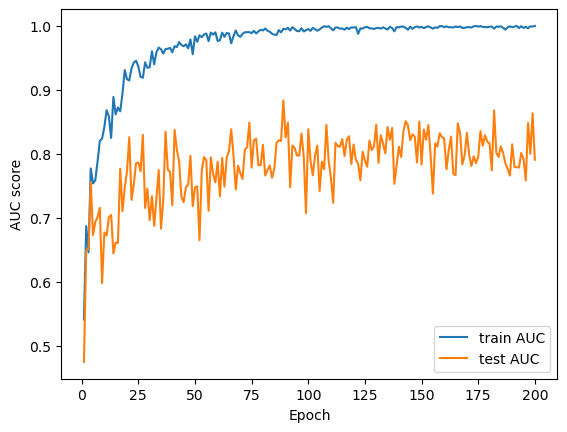

In [13]:
best_auc = 0
best_acc = 0
best_epoch = 0

train_auc_scores = []
test_auc_scores = []
epochs = []

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    train_loss = 0
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        targets = targets.squeeze().long()
        loss = criterion(outputs, targets)  # Use this line for both tasks
            
        loss.backward()
        optimizer.step()
    
    # Evaluate after each epoch
    print(f"==> Evaluating after epoch {epoch + 1} ...")
    train_metrics = evaluate(train_loader)
    test_metrics = evaluate(test_loader)
    
    print(f"Train AUC: {train_metrics[0]}, Train ACC: {train_metrics[1]}")
    print(f"Test AUC: {test_metrics[0]}, Test ACC: {test_metrics[1]}")

    # Check if AUC score improved
    if test_metrics[0] > best_auc:
        best_auc = test_metrics[0]
        best_acc = test_metrics[1]
        best_epoch = epoch + 1
        print(f"==> Best test AUC and ACC score updated: {best_auc:.4f}, {best_acc:.4f}")
        # Save the model state
        torch.save(model.state_dict(), 'best_pretraind_model_breastmnist.pth')
    
    # Append AUC scores and epoch numbers
    train_auc_scores.append(train_metrics[0])
    test_auc_scores.append(test_metrics[0])
    epochs.append(epoch+1)

print(f"Best test AUC: {best_auc:.4f} and ACC: {best_acc:.4f} achieved at epoch {best_epoch}")

# Plot the train and test AUC scores vs epoch
plt.plot(epochs, train_auc_scores, label='train AUC')
plt.plot(epochs, test_auc_scores, label='test AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC score')
plt.show()

# LibAUC

In [10]:
# Get the current working directory
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

# List the files in the current directory
files = os.listdir(current_directory)
print("Files in the current directory:")
for file in files:
    print(file)

Current working directory: d:\Download\CSCE633\project
Files in the current directory:
AdrenalMNIST3D.ipynb
best_model_adrenalmnist3d.pth
best_model_breastmnist.pth
best_model_breastmnist_no_dropout.pth
best_model_chestmnist.pth
best_model_nodulemnist3d.pth
best_model_pneumoniamnist.pth
best_model_pneumoniamnist_no_dropout.pth
best_model_synapsemnist3d.pth
best_pretraind_model_breastmnist.pth
best_pretraind_model_pneumoniamnist.pth
best_pretrained_model_adrenalmnist3d.pth
best_pretrained_model_chestmnist.pth
best_pretrained_model_nodulemnist3d.pth
best_pretrained_model_pneumoniamnist.pth
best_pretrained_model_synapsemnist3d.pth
best_pretrained_model_vesselmnist3d.pth
BreastMNIST.ipynb
ChestMNIST.ipynb
CSE633-Spring23-Project-Description.pdf.pdf
data
get_started.ipynb
load_all_data.ipynb
NoduleMNIST3D.ipynb
PneumoniaMNIST.ipynb
resnet2p1d.py
SynapseMNIST3D.ipynb
VesselMNIST3D.ipynb
__pycache__


## ResNet18 with dropout

In [25]:
from torchvision.models.resnet import ResNet, BasicBlock
class ResNet18WithDropout(ResNet):
    def __init__(self, num_classes=2, dropout_rate=0.7):
        super(ResNet18WithDropout, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
        self.dropout_rate = dropout_rate
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Change the input channels to 1
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)  # Change the output size to match the pretrained model

# Instantiate the modified ResNet18 with dropout
model = ResNet18WithDropout(dropout_rate=0.7)

# Load the state dictionary from the .pth file
pretrained_weights = torch.load("best_pretraind_model_breastmnist.pth")

In [26]:
def fix_state_dict_keys(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

fixed_pretrained_weights = fix_state_dict_keys(pretrained_weights)

In [27]:
# Transfer the weights from the pretrained model to the modified model with dropout
model.load_state_dict(fixed_pretrained_weights, strict=False)

<All keys matched successfully>

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet18WithDropout(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inp

parameters  

In [29]:
SEED = 123
BATCH_SIZE = 128
lr = 0.001 
epoch_decay = 2e-3
weight_decay = 1e-5
margin = 1.0

In [30]:
# define loss & optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model, 
                 loss_fn=loss_fn, 
                 lr=lr, 
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)

100%|██████████| 9/9 [00:00<00:00, 18.55it/s]


==> Evaluating after epoch 1 ...
Train AUC: 0.9533481191389599, Train ACC: 38.413919413919416
Test AUC: 0.6897739741057713, Test ACC: 67.16666666666667
==> Best test AUC and ACC score updated: 0.6898, 67.1667


100%|██████████| 9/9 [00:00<00:00, 24.19it/s]


==> Evaluating after epoch 2 ...
Train AUC: 0.9323987269035177, Train ACC: 37.875457875457876
Test AUC: 0.6717138468290542, Test ACC: 66.8076923076923


100%|██████████| 9/9 [00:00<00:00, 25.11it/s]


==> Evaluating after epoch 3 ...
Train AUC: 0.908094996219075, Train ACC: 37.663003663003664
Test AUC: 0.5465437788018432, Test ACC: 64.94871794871794


100%|██████████| 9/9 [00:00<00:00, 21.59it/s]


==> Evaluating after epoch 4 ...
Train AUC: 0.9091548556563929, Train ACC: 36.937728937728934
Test AUC: 0.6377441299100286, Test ACC: 66.33333333333333


100%|██████████| 9/9 [00:00<00:00, 24.83it/s]


==> Evaluating after epoch 5 ...
Train AUC: 0.871354093359486, Train ACC: 36.095238095238095
Test AUC: 0.61724818959842, Test ACC: 63.55128205128205


100%|██████████| 9/9 [00:00<00:00, 25.35it/s]


==> Evaluating after epoch 6 ...
Train AUC: 0.8434684716606199, Train ACC: 36.42490842490842
Test AUC: 0.6162826420890937, Test ACC: 62.717948717948715


100%|██████████| 9/9 [00:00<00:00, 25.37it/s]


==> Evaluating after epoch 7 ...
Train AUC: 0.8547212575291455, Train ACC: 35.934065934065934
Test AUC: 0.633838051349572, Test ACC: 62.717948717948715


100%|██████████| 9/9 [00:00<00:00, 25.40it/s]


==> Evaluating after epoch 8 ...
Train AUC: 0.8561485421016296, Train ACC: 35.81684981684982
Test AUC: 0.6025235900811937, Test ACC: 58.92307692307692


100%|██████████| 9/9 [00:00<00:00, 25.49it/s]


==> Evaluating after epoch 9 ...
Train AUC: 0.8370835232547515, Train ACC: 35.34065934065934
Test AUC: 0.5487601492209787, Test ACC: 62.07692307692308


100%|██████████| 9/9 [00:00<00:00, 25.90it/s]


==> Evaluating after epoch 10 ...
Train AUC: 0.8319937654531953, Train ACC: 35.49084249084249
Test AUC: 0.606276058810621, Test ACC: 63.46153846153846


100%|██████████| 9/9 [00:00<00:00, 25.11it/s]


==> Evaluating after epoch 11 ...
Train AUC: 0.8238757805861175, Train ACC: 34.1025641025641
Test AUC: 0.508953258722844, Test ACC: 60.48717948717949


100%|██████████| 9/9 [00:00<00:00, 25.71it/s]


==> Evaluating after epoch 12 ...
Train AUC: 0.8345463969373207, Train ACC: 34.37362637362637
Test AUC: 0.6354180381830151, Test ACC: 60.67948717948718


100%|██████████| 9/9 [00:00<00:00, 24.30it/s]


==> Evaluating after epoch 13 ...
Train AUC: 0.8494152378831221, Train ACC: 34.08058608058608
Test AUC: 0.5554970375246873, Test ACC: 54.44871794871795


100%|██████████| 9/9 [00:00<00:00, 24.24it/s]


==> Evaluating after epoch 14 ...
Train AUC: 0.850360050221307, Train ACC: 34.9010989010989
Test AUC: 0.5825104235242484, Test ACC: 61.97435897435897


100%|██████████| 9/9 [00:00<00:00, 23.29it/s]


==> Evaluating after epoch 15 ...
Train AUC: 0.8129258703975045, Train ACC: 34.72527472527472
Test AUC: 0.6540048277375466, Test ACC: 59.666666666666664


100%|██████████| 9/9 [00:00<00:00, 25.45it/s]


==> Evaluating after epoch 16 ...
Train AUC: 0.8319291163070801, Train ACC: 34.6996336996337
Test AUC: 0.7238314680710993, Test ACC: 59.294871794871796
==> Best test AUC and ACC score updated: 0.7238, 59.2949


100%|██████████| 9/9 [00:00<00:00, 25.62it/s]


==> Evaluating after epoch 17 ...
Train AUC: 0.8248855668579407, Train ACC: 33.70695970695971
Test AUC: 0.6609831029185868, Test ACC: 59.47435897435897


100%|██████████| 9/9 [00:00<00:00, 25.24it/s]


==> Evaluating after epoch 18 ...
Train AUC: 0.8337115696836013, Train ACC: 34.08058608058608
Test AUC: 0.5083388193987273, Test ACC: 63.08974358974359


100%|██████████| 9/9 [00:00<00:00, 25.37it/s]


==> Evaluating after epoch 19 ...
Train AUC: 0.8405518112343862, Train ACC: 34.05494505494506
Test AUC: 0.6105113012947114, Test ACC: 56.96153846153846


100%|██████████| 9/9 [00:00<00:00, 25.04it/s]


==> Evaluating after epoch 20 ...
Train AUC: 0.7938429334191434, Train ACC: 34.205128205128204
Test AUC: 0.6195084485407065, Test ACC: 58.93589743589744


100%|██████████| 9/9 [00:00<00:00, 24.45it/s]


==> Evaluating after epoch 21 ...
Train AUC: 0.8120356151158871, Train ACC: 34.362637362637365
Test AUC: 0.5559798112793505, Test ACC: 55.94871794871795


100%|██████████| 9/9 [00:00<00:00, 24.92it/s]


==> Evaluating after epoch 22 ...
Train AUC: 0.8302392589187898, Train ACC: 32.21978021978022
Test AUC: 0.6465876673249945, Test ACC: 55.30769230769231


100%|██████████| 9/9 [00:00<00:00, 25.14it/s]


==> Evaluating after epoch 23 ...
Train AUC: 0.837490275293653, Train ACC: 32.76923076923077
Test AUC: 0.6588983980689049, Test ACC: 54.46153846153846


100%|██████████| 9/9 [00:00<00:00, 24.15it/s]


==> Evaluating after epoch 24 ...
Train AUC: 0.8428974580404448, Train ACC: 32.61538461538461
Test AUC: 0.6083827079218784, Test ACC: 58.44871794871795


100%|██████████| 9/9 [00:00<00:00, 25.24it/s]


==> Evaluating after epoch 25 ...
Train AUC: 0.8736550620408282, Train ACC: 33.772893772893774
Test AUC: 0.728000877770463, Test ACC: 57.53846153846154
==> Best test AUC and ACC score updated: 0.7280, 57.5385


100%|██████████| 9/9 [00:00<00:00, 25.32it/s]


==> Evaluating after epoch 26 ...
Train AUC: 0.8517163568052761, Train ACC: 33.05128205128205
Test AUC: 0.7306561334211104, Test ACC: 55.666666666666664
==> Best test AUC and ACC score updated: 0.7307, 55.6667


100%|██████████| 9/9 [00:00<00:00, 24.94it/s]


==> Evaluating after epoch 27 ...
Train AUC: 0.8382306194368159, Train ACC: 33.065934065934066
Test AUC: 0.5233267500548606, Test ACC: 54.82051282051282


100%|██████████| 9/9 [00:00<00:00, 24.95it/s]


==> Evaluating after epoch 28 ...
Train AUC: 0.8526883012396181, Train ACC: 33.72893772893773
Test AUC: 0.48470484968180816, Test ACC: 58.73076923076923


100%|██████████| 9/9 [00:00<00:00, 25.66it/s]


==> Evaluating after epoch 29 ...
Train AUC: 0.8801028559421297, Train ACC: 33.63003663003663
Test AUC: 0.6763879745446566, Test ACC: 57.15384615384615


100%|██████████| 9/9 [00:00<00:00, 25.05it/s]


==> Evaluating after epoch 30 ...
Train AUC: 0.8276325844685943, Train ACC: 32.29304029304029
Test AUC: 0.6402677199912223, Test ACC: 55.56410256410256


100%|██████████| 9/9 [00:00<00:00, 24.35it/s]


==> Evaluating after epoch 31 ...
Train AUC: 0.8336444304928963, Train ACC: 32.86446886446886
Test AUC: 0.6600394996708361, Test ACC: 54.92307692307692


100%|██████████| 9/9 [00:00<00:00, 24.39it/s]


==> Evaluating after epoch 32 ...
Train AUC: 0.8675103720755897, Train ACC: 32.96336996336996
Test AUC: 0.5088654816765416, Test ACC: 57.61538461538461


100%|██████████| 9/9 [00:00<00:00, 24.05it/s]


==> Evaluating after epoch 33 ...
Train AUC: 0.8752833607380737, Train ACC: 33.498168498168496
Test AUC: 0.6837612464340574, Test ACC: 54.833333333333336


100%|██████████| 9/9 [00:00<00:00, 23.19it/s]


==> Evaluating after epoch 34 ...
Train AUC: 0.9059407639399618, Train ACC: 33.12820512820513
Test AUC: 0.6634189159534782, Test ACC: 52.62820512820513


100%|██████████| 9/9 [00:00<00:00, 22.82it/s]


==> Evaluating after epoch 35 ...
Train AUC: 0.8960115964895903, Train ACC: 33.35897435897436
Test AUC: 0.6810840465218345, Test ACC: 60.03846153846154


100%|██████████| 9/9 [00:00<00:00, 21.19it/s]


==> Evaluating after epoch 36 ...
Train AUC: 0.8709063011833066, Train ACC: 32.663003663003664
Test AUC: 0.6865481676541585, Test ACC: 58.56410256410256


100%|██████████| 9/9 [00:00<00:00, 20.83it/s]


==> Evaluating after epoch 37 ...
Train AUC: 0.8617889184866676, Train ACC: 33.61538461538461
Test AUC: 0.6839368005266624, Test ACC: 57.243589743589745


100%|██████████| 9/9 [00:00<00:00, 22.06it/s]


==> Evaluating after epoch 38 ...
Train AUC: 0.9062947882278531, Train ACC: 32.35531135531136
Test AUC: 0.6275619925389511, Test ACC: 57.717948717948715


100%|██████████| 9/9 [00:00<00:00, 23.47it/s]


==> Evaluating after epoch 39 ...
Train AUC: 0.882384224984337, Train ACC: 32.99267399267399
Test AUC: 0.6129690585911785, Test ACC: 52.96153846153846


100%|██████████| 9/9 [00:00<00:00, 23.42it/s]


==> Evaluating after epoch 40 ...
Train AUC: 0.9163397820929037, Train ACC: 33.86813186813187
Test AUC: 0.7464340574939654, Test ACC: 60.782051282051285
==> Best test AUC and ACC score updated: 0.7464, 60.7821


100%|██████████| 9/9 [00:00<00:00, 24.38it/s]


==> Evaluating after epoch 41 ...
Train AUC: 0.9003808369311312, Train ACC: 32.765567765567766
Test AUC: 0.709062980030722, Test ACC: 55.57692307692308


100%|██████████| 9/9 [00:00<00:00, 23.79it/s]


==> Evaluating after epoch 42 ...
Train AUC: 0.9093663801369194, Train ACC: 32.37362637362637
Test AUC: 0.7084046521834539, Test ACC: 54.08974358974359


100%|██████████| 9/9 [00:00<00:00, 24.48it/s]


==> Evaluating after epoch 43 ...
Train AUC: 0.9179900486859379, Train ACC: 30.912087912087912
Test AUC: 0.6714285714285715, Test ACC: 54.46153846153846


100%|██████████| 9/9 [00:00<00:00, 24.70it/s]


==> Evaluating after epoch 44 ...
Train AUC: 0.9107378555639192, Train ACC: 31.824175824175825
Test AUC: 0.7087777046302393, Test ACC: 54.282051282051285


100%|██████████| 9/9 [00:00<00:00, 22.22it/s]


==> Evaluating after epoch 45 ...
Train AUC: 0.9237990470557074, Train ACC: 33.73626373626374
Test AUC: 0.6445687952600394, Test ACC: 56.794871794871796


100%|██████████| 9/9 [00:00<00:00, 23.66it/s]


==> Evaluating after epoch 46 ...
Train AUC: 0.9396283208962812, Train ACC: 32.92673992673993
Test AUC: 0.663594470046083, Test ACC: 58.282051282051285


100%|██████████| 9/9 [00:00<00:00, 23.94it/s]


==> Evaluating after epoch 47 ...
Train AUC: 0.9293520046327937, Train ACC: 35.16117216117216
Test AUC: 0.8026333113890718, Test ACC: 60.217948717948715
==> Best test AUC and ACC score updated: 0.8026, 60.2179


100%|██████████| 9/9 [00:00<00:00, 23.61it/s]


==> Evaluating after epoch 48 ...
Train AUC: 0.9078949948889967, Train ACC: 33.443223443223445
Test AUC: 0.7349572086899276, Test ACC: 57.15384615384615


100%|██████████| 9/9 [00:00<00:00, 23.84it/s]


==> Evaluating after epoch 49 ...
Train AUC: 0.9059716718472822, Train ACC: 34.15750915750916
Test AUC: 0.7964230853631775, Test ACC: 60.782051282051285


100%|██████████| 9/9 [00:00<00:00, 23.88it/s]


==> Evaluating after epoch 50 ...
Train AUC: 0.9138742817812572, Train ACC: 32.366300366300365
Test AUC: 0.7004169409699363, Test ACC: 54.19230769230769


100%|██████████| 9/9 [00:00<00:00, 23.69it/s]


==> Evaluating after epoch 51 ...
Train AUC: 0.935970917646178, Train ACC: 32.83516483516483
Test AUC: 0.7964011411016019, Test ACC: 54.44871794871795


100%|██████████| 9/9 [00:00<00:00, 23.08it/s]


==> Evaluating after epoch 52 ...
Train AUC: 0.930038269940741, Train ACC: 32.58974358974359
Test AUC: 0.7527320605661619, Test ACC: 58.26923076923077


100%|██████████| 9/9 [00:00<00:00, 22.78it/s]


==> Evaluating after epoch 53 ...
Train AUC: 0.9458108432429084, Train ACC: 32.51648351648352
Test AUC: 0.6981786262892253, Test ACC: 55.76923076923077


100%|██████████| 9/9 [00:00<00:00, 23.60it/s]


==> Evaluating after epoch 54 ...
Train AUC: 0.9269778048310366, Train ACC: 33.062271062271066
Test AUC: 0.7601931095018652, Test ACC: 58.833333333333336


100%|██████████| 9/9 [00:00<00:00, 24.12it/s]


==> Evaluating after epoch 55 ...
Train AUC: 0.9325834228689901, Train ACC: 33.395604395604394
Test AUC: 0.6186526223392583, Test ACC: 58.37179487179487


100%|██████████| 9/9 [00:00<00:00, 23.48it/s]


==> Evaluating after epoch 56 ...
Train AUC: 0.9479994323674377, Train ACC: 31.65934065934066
Test AUC: 0.7565064735571647, Test ACC: 55.30769230769231


100%|██████████| 9/9 [00:00<00:00, 20.32it/s]


==> Evaluating after epoch 57 ...
Train AUC: 0.9469032701626064, Train ACC: 31.05860805860806
Test AUC: 0.6682466535001097, Test ACC: 58.65384615384615


100%|██████████| 9/9 [00:00<00:00, 21.16it/s]


==> Evaluating after epoch 58 ...
Train AUC: 0.9362089773296228, Train ACC: 32.27472527472528
Test AUC: 0.7188501206934386, Test ACC: 55.48717948717949


100%|██████████| 9/9 [00:00<00:00, 21.76it/s]


==> Evaluating after epoch 59 ...
Train AUC: 0.9395970332091655, Train ACC: 33.16483516483517
Test AUC: 0.7596225587008996, Test ACC: 58.91025641025641


100%|██████████| 9/9 [00:00<00:00, 22.20it/s]


==> Evaluating after epoch 60 ...
Train AUC: 0.964173639027528, Train ACC: 32.65934065934066
Test AUC: 0.7730085582620145, Test ACC: 57.80769230769231


100%|██████████| 9/9 [00:00<00:00, 23.05it/s]


==> Evaluating after epoch 61 ...
Train AUC: 0.9561149252527503, Train ACC: 31.626373626373628
Test AUC: 0.6304805793285055, Test ACC: 59.205128205128204


100%|██████████| 9/9 [00:00<00:00, 23.83it/s]


==> Evaluating after epoch 62 ...
Train AUC: 0.9550305067172302, Train ACC: 32.498168498168496
Test AUC: 0.7593372833004169, Test ACC: 52.51282051282051


100%|██████████| 9/9 [00:00<00:00, 24.24it/s]


==> Evaluating after epoch 63 ...
Train AUC: 0.9616139694315355, Train ACC: 33.10622710622711
Test AUC: 0.7218125960061443, Test ACC: 55.30769230769231


100%|██████████| 9/9 [00:00<00:00, 24.27it/s]


==> Evaluating after epoch 64 ...
Train AUC: 0.9575550110638087, Train ACC: 33.505494505494504
Test AUC: 0.7750713188501207, Test ACC: 57.333333333333336


100%|██████████| 9/9 [00:00<00:00, 23.89it/s]


==> Evaluating after epoch 65 ...
Train AUC: 0.9592539831642516, Train ACC: 30.805860805860807
Test AUC: 0.6969716919025675, Test ACC: 54.01282051282051


100%|██████████| 9/9 [00:00<00:00, 23.94it/s]


==> Evaluating after epoch 66 ...
Train AUC: 0.9718153452383906, Train ACC: 32.57509157509158
Test AUC: 0.6834320825104234, Test ACC: 57.91025641025641


100%|██████████| 9/9 [00:00<00:00, 24.98it/s]


==> Evaluating after epoch 67 ...
Train AUC: 0.9753211838905239, Train ACC: 33.37728937728938
Test AUC: 0.8176651305683564, Test ACC: 56.782051282051285
==> Best test AUC and ACC score updated: 0.8177, 56.7821


100%|██████████| 9/9 [00:00<00:00, 22.56it/s]


==> Evaluating after epoch 68 ...
Train AUC: 0.9608676622080655, Train ACC: 32.776556776556774
Test AUC: 0.7463243361860874, Test ACC: 56.69230769230769


100%|██████████| 9/9 [00:00<00:00, 23.24it/s]


==> Evaluating after epoch 69 ...
Train AUC: 0.9571776023973803, Train ACC: 33.08058608058608
Test AUC: 0.7292955892034233, Test ACC: 55.84615384615385


100%|██████████| 9/9 [00:00<00:00, 24.46it/s]


==> Evaluating after epoch 70 ...
Train AUC: 0.9714245266541887, Train ACC: 33.553113553113555
Test AUC: 0.7496598639455783, Test ACC: 54.35897435897436


100%|██████████| 9/9 [00:00<00:00, 24.69it/s]


==> Evaluating after epoch 71 ...
Train AUC: 0.9685094501287155, Train ACC: 30.87912087912088
Test AUC: 0.7576695194206715, Test ACC: 59.217948717948715


100%|██████████| 9/9 [00:00<00:00, 23.88it/s]


==> Evaluating after epoch 72 ...
Train AUC: 0.9537125563558746, Train ACC: 32.84981684981685
Test AUC: 0.715119596225587, Test ACC: 53.256410256410255


100%|██████████| 9/9 [00:00<00:00, 24.78it/s]


==> Evaluating after epoch 73 ...
Train AUC: 0.9611528845313306, Train ACC: 32.959706959706956
Test AUC: 0.7659205617730963, Test ACC: 57.8974358974359


100%|██████████| 9/9 [00:00<00:00, 23.99it/s]


==> Evaluating after epoch 74 ...
Train AUC: 0.9674921752720951, Train ACC: 34.38827838827839
Test AUC: 0.7707482993197279, Test ACC: 58.26923076923077


100%|██████████| 9/9 [00:00<00:00, 24.30it/s]


==> Evaluating after epoch 75 ...
Train AUC: 0.9793683520706852, Train ACC: 31.952380952380953
Test AUC: 0.7451393460610051, Test ACC: 55.294871794871796


100%|██████████| 9/9 [00:00<00:00, 22.50it/s]


==> Evaluating after epoch 76 ...
Train AUC: 0.9753080529963515, Train ACC: 32.2967032967033
Test AUC: 0.8149659863945578, Test ACC: 54.08974358974359


100%|██████████| 9/9 [00:00<00:00, 24.83it/s]


==> Evaluating after epoch 77 ...
Train AUC: 0.9628561927553585, Train ACC: 32.88644688644688
Test AUC: 0.6914636822470924, Test ACC: 57.80769230769231


100%|██████████| 9/9 [00:00<00:00, 24.19it/s]


==> Evaluating after epoch 78 ...
Train AUC: 0.9671593979270177, Train ACC: 32.94871794871795
Test AUC: 0.7877112135176652, Test ACC: 60.14102564102564


100%|██████████| 9/9 [00:00<00:00, 22.27it/s]


==> Evaluating after epoch 79 ...
Train AUC: 0.9757675894170189, Train ACC: 32.10989010989011
Test AUC: 0.7538073293833663, Test ACC: 58.55128205128205


100%|██████████| 9/9 [00:00<00:00, 22.56it/s]


==> Evaluating after epoch 80 ...
Train AUC: 0.976816392409826, Train ACC: 33.67032967032967
Test AUC: 0.8167215273206057, Test ACC: 57.06410256410256


100%|██████████| 9/9 [00:00<00:00, 23.07it/s]


==> Evaluating after epoch 81 ...
Train AUC: 0.9738728191619942, Train ACC: 31.945054945054945
Test AUC: 0.7849681808207154, Test ACC: 54.93589743589744


100%|██████████| 9/9 [00:00<00:00, 23.28it/s]


==> Evaluating after epoch 82 ...
Train AUC: 0.9840057216836069, Train ACC: 31.454212454212453
Test AUC: 0.7043449637919683, Test ACC: 58.0


100%|██████████| 9/9 [00:00<00:00, 24.64it/s]


==> Evaluating after epoch 83 ...
Train AUC: 0.9830721416099111, Train ACC: 31.6996336996337
Test AUC: 0.7337502743032698, Test ACC: 56.6025641025641


100%|██████████| 9/9 [00:00<00:00, 23.86it/s]


==> Evaluating after epoch 84 ...
Train AUC: 0.9814947049138225, Train ACC: 31.553113553113555
Test AUC: 0.7564845292955893, Test ACC: 54.65384615384615


100%|██████████| 9/9 [00:00<00:00, 23.74it/s]


==> Evaluating after epoch 85 ...
Train AUC: 0.9813115407153925, Train ACC: 32.64835164835165
Test AUC: 0.7860873381610708, Test ACC: 54.37179487179487


100%|██████████| 9/9 [00:00<00:00, 23.97it/s]


==> Evaluating after epoch 86 ...
Train AUC: 0.9853251967795453, Train ACC: 33.6007326007326
Test AUC: 0.7109062980030723, Test ACC: 57.333333333333336


100%|██████████| 9/9 [00:00<00:00, 24.50it/s]


==> Evaluating after epoch 87 ...
Train AUC: 0.9683991348832909, Train ACC: 33.51282051282051
Test AUC: 0.7822909809084924, Test ACC: 59.294871794871796


100%|██████████| 9/9 [00:00<00:00, 24.30it/s]


==> Evaluating after epoch 88 ...
Train AUC: 0.9843080629947207, Train ACC: 33.29304029304029
Test AUC: 0.7224709238534124, Test ACC: 52.88461538461539


100%|██████████| 9/9 [00:00<00:00, 24.10it/s]


==> Evaluating after epoch 89 ...
Train AUC: 0.9695169673856413, Train ACC: 31.761904761904763
Test AUC: 0.7226464779460171, Test ACC: 53.64102564102564


100%|██████████| 9/9 [00:00<00:00, 24.36it/s]


==> Evaluating after epoch 90 ...
Train AUC: 0.9870740411722116, Train ACC: 31.377289377289376
Test AUC: 0.753873162168093, Test ACC: 57.256410256410255


100%|██████████| 9/9 [00:00<00:00, 24.57it/s]


==> Evaluating after epoch 91 ...
Train AUC: 0.973904314556082, Train ACC: 32.1978021978022
Test AUC: 0.7538512179065174, Test ACC: 57.705128205128204


100%|██████████| 9/9 [00:00<00:00, 23.47it/s]


==> Evaluating after epoch 92 ...
Train AUC: 0.9813378397354973, Train ACC: 32.32234432234432
Test AUC: 0.7466535001097212, Test ACC: 56.32051282051282


100%|██████████| 9/9 [00:00<00:00, 24.12it/s]


==> Evaluating after epoch 93 ...
Train AUC: 0.9884211675343254, Train ACC: 32.4029304029304
Test AUC: 0.7634408602150538, Test ACC: 56.02564102564103


100%|██████████| 9/9 [00:00<00:00, 24.51it/s]


==> Evaluating after epoch 94 ...
Train AUC: 0.9742050290354572, Train ACC: 31.68864468864469
Test AUC: 0.7463023919245118, Test ACC: 54.84615384615385


100%|██████████| 9/9 [00:00<00:00, 24.87it/s]


==> Evaluating after epoch 95 ...
Train AUC: 0.9736602505157186, Train ACC: 31.684981684981686
Test AUC: 0.7590520078999341, Test ACC: 53.43589743589744


100%|██████████| 9/9 [00:00<00:00, 20.97it/s]


==> Evaluating after epoch 96 ...
Train AUC: 0.9889802072815912, Train ACC: 31.897435897435898
Test AUC: 0.7189159534781655, Test ACC: 56.12820512820513


100%|██████████| 9/9 [00:00<00:00, 21.03it/s]


==> Evaluating after epoch 97 ...
Train AUC: 0.978661925824897, Train ACC: 32.94871794871795
Test AUC: 0.8210006583278473, Test ACC: 60.23076923076923
==> Best test AUC and ACC score updated: 0.8210, 60.2308


100%|██████████| 9/9 [00:00<00:00, 21.84it/s]


==> Evaluating after epoch 98 ...
Train AUC: 0.9876914756802226, Train ACC: 31.454212454212453
Test AUC: 0.7423304805793285, Test ACC: 56.88461538461539


100%|██████████| 9/9 [00:00<00:00, 24.40it/s]


==> Evaluating after epoch 99 ...
Train AUC: 0.9854525143642152, Train ACC: 32.2967032967033
Test AUC: 0.789027869212201, Test ACC: 58.65384615384615


100%|██████████| 9/9 [00:00<00:00, 24.47it/s]


==> Evaluating after epoch 100 ...
Train AUC: 0.9767305746791494, Train ACC: 31.641025641025642
Test AUC: 0.7310730743910467, Test ACC: 55.1025641025641


100%|██████████| 9/9 [00:00<00:00, 21.04it/s]


==> Evaluating after epoch 101 ...
Train AUC: 0.9806287779120088, Train ACC: 32.937728937728934
Test AUC: 0.7706385780118499, Test ACC: 58.06410256410256


100%|██████████| 9/9 [00:00<00:00, 21.23it/s]


==> Evaluating after epoch 102 ...
Train AUC: 0.9878584320839935, Train ACC: 32.84981684981685
Test AUC: 0.8137151634847488, Test ACC: 59.37179487179487


100%|██████████| 9/9 [00:00<00:00, 23.44it/s]


==> Evaluating after epoch 103 ...
Train AUC: 0.9876427211710718, Train ACC: 33.527472527472526
Test AUC: 0.7827079218784287, Test ACC: 53.07692307692308


100%|██████████| 9/9 [00:00<00:00, 23.60it/s]


==> Evaluating after epoch 104 ...
Train AUC: 0.9946013853816448, Train ACC: 31.56776556776557
Test AUC: 0.7452051788457319, Test ACC: 59.19230769230769


100%|██████████| 9/9 [00:00<00:00, 23.97it/s]


==> Evaluating after epoch 105 ...
Train AUC: 0.9915960257678057, Train ACC: 31.94139194139194
Test AUC: 0.711301294711433, Test ACC: 55.3974358974359


100%|██████████| 9/9 [00:00<00:00, 25.43it/s]


==> Evaluating after epoch 106 ...
Train AUC: 0.9865482053933385, Train ACC: 32.45787545787546
Test AUC: 0.791595347816546, Test ACC: 52.05128205128205


100%|██████████| 9/9 [00:00<00:00, 24.76it/s]


==> Evaluating after epoch 107 ...
Train AUC: 0.9874387417514122, Train ACC: 31.68864468864469
Test AUC: 0.8038841342988808, Test ACC: 54.92307692307692


100%|██████████| 9/9 [00:00<00:00, 25.59it/s]


==> Evaluating after epoch 108 ...
Train AUC: 0.9863765193609565, Train ACC: 31.3003663003663
Test AUC: 0.8350449857362299, Test ACC: 55.3974358974359
==> Best test AUC and ACC score updated: 0.8350, 55.3974


100%|██████████| 9/9 [00:00<00:00, 24.18it/s]


==> Evaluating after epoch 109 ...
Train AUC: 0.9917894430249581, Train ACC: 32.32600732600733
Test AUC: 0.7427035330261136, Test ACC: 54.64102564102564


100%|██████████| 9/9 [00:00<00:00, 25.56it/s]


==> Evaluating after epoch 110 ...
Train AUC: 0.9924974011306378, Train ACC: 32.556776556776555
Test AUC: 0.6935483870967742, Test ACC: 57.61538461538461


100%|██████████| 9/9 [00:00<00:00, 25.42it/s]


==> Evaluating after epoch 111 ...
Train AUC: 0.9912729381341189, Train ACC: 32.091575091575095
Test AUC: 0.7543998244459074, Test ACC: 54.93589743589744


100%|██████████| 9/9 [00:00<00:00, 24.82it/s]


==> Evaluating after epoch 112 ...
Train AUC: 0.9908929580746898, Train ACC: 31.032967032967033
Test AUC: 0.7183892912003511, Test ACC: 54.07692307692308


100%|██████████| 9/9 [00:00<00:00, 24.90it/s]


==> Evaluating after epoch 113 ...
Train AUC: 0.9859584417020868, Train ACC: 31.326007326007325
Test AUC: 0.7781215712091288, Test ACC: 58.44871794871795


100%|██████████| 9/9 [00:00<00:00, 24.66it/s]


==> Evaluating after epoch 114 ...
Train AUC: 0.9809886420816455, Train ACC: 32.02197802197802
Test AUC: 0.7533684441518543, Test ACC: 56.69230769230769


100%|██████████| 9/9 [00:00<00:00, 25.24it/s]


==> Evaluating after epoch 115 ...
Train AUC: 0.9890572214460798, Train ACC: 32.20879120879121
Test AUC: 0.7999341672152732, Test ACC: 55.11538461538461


100%|██████████| 9/9 [00:00<00:00, 23.82it/s]


==> Evaluating after epoch 116 ...
Train AUC: 0.9932461707393221, Train ACC: 30.714285714285715
Test AUC: 0.7141540487162608, Test ACC: 55.5


100%|██████████| 9/9 [00:00<00:00, 23.59it/s]


==> Evaluating after epoch 117 ...
Train AUC: 0.9915483904468831, Train ACC: 31.67765567765568
Test AUC: 0.7692780337941629, Test ACC: 55.96153846153846


100%|██████████| 9/9 [00:00<00:00, 22.47it/s]


==> Evaluating after epoch 118 ...
Train AUC: 0.986509664908473, Train ACC: 33.20879120879121
Test AUC: 0.8036646916831249, Test ACC: 54.0


100%|██████████| 9/9 [00:00<00:00, 23.92it/s]


==> Evaluating after epoch 119 ...
Train AUC: 0.9956572346880335, Train ACC: 32.02930402930403
Test AUC: 0.7916392363396971, Test ACC: 55.57692307692308


100%|██████████| 9/9 [00:00<00:00, 22.58it/s]


==> Evaluating after epoch 120 ...
Train AUC: 0.9938824154812804, Train ACC: 32.311355311355314
Test AUC: 0.7595128373930218, Test ACC: 60.14102564102564


100%|██████████| 9/9 [00:00<00:00, 25.13it/s]


==> Evaluating after epoch 121 ...
Train AUC: 0.9914733098464716, Train ACC: 32.84981684981685
Test AUC: 0.7746324336186088, Test ACC: 55.84615384615385


100%|██████████| 9/9 [00:00<00:00, 23.93it/s]


==> Evaluating after epoch 122 ...
Train AUC: 0.995076459837377, Train ACC: 32.79120879120879
Test AUC: 0.7238095238095238, Test ACC: 56.58974358974359


100%|██████████| 9/9 [00:00<00:00, 24.05it/s]


==> Evaluating after epoch 123 ...
Train AUC: 0.9951259215441411, Train ACC: 34.175824175824175
Test AUC: 0.7306561334211104, Test ACC: 57.8974358974359


100%|██████████| 9/9 [00:00<00:00, 24.10it/s]


==> Evaluating after epoch 124 ...
Train AUC: 0.9884586798756543, Train ACC: 32.08058608058608
Test AUC: 0.7554312047399605, Test ACC: 55.11538461538461


100%|██████████| 9/9 [00:00<00:00, 22.41it/s]


==> Evaluating after epoch 125 ...
Train AUC: 0.9948337185397228, Train ACC: 32.227106227106226
Test AUC: 0.7415185429010314, Test ACC: 52.717948717948715


100%|██████████| 9/9 [00:00<00:00, 23.02it/s]


==> Evaluating after epoch 126 ...
Train AUC: 0.9896939373863289, Train ACC: 32.095238095238095
Test AUC: 0.8044107965766952, Test ACC: 54.19230769230769


100%|██████████| 9/9 [00:00<00:00, 25.39it/s]


==> Evaluating after epoch 127 ...
Train AUC: 0.992669248380265, Train ACC: 32.65934065934066
Test AUC: 0.8198815009874918, Test ACC: 59.19230769230769


100%|██████████| 9/9 [00:00<00:00, 24.45it/s]


==> Evaluating after epoch 128 ...
Train AUC: 0.995512030595111, Train ACC: 30.652014652014653
Test AUC: 0.7782312925170068, Test ACC: 55.48717948717949


100%|██████████| 9/9 [00:00<00:00, 23.16it/s]


==> Evaluating after epoch 129 ...
Train AUC: 0.9860807667771608, Train ACC: 31.963369963369964
Test AUC: 0.7784726793943384, Test ACC: 58.38461538461539


100%|██████████| 9/9 [00:00<00:00, 25.73it/s]


==> Evaluating after epoch 130 ...
Train AUC: 0.9926785582543004, Train ACC: 32.095238095238095
Test AUC: 0.7393460610050472, Test ACC: 57.333333333333336


100%|██████████| 9/9 [00:00<00:00, 25.11it/s]


==> Evaluating after epoch 131 ...
Train AUC: 0.9885011132830148, Train ACC: 32.45054945054945
Test AUC: 0.7944700460829492, Test ACC: 55.57692307692308


100%|██████████| 9/9 [00:00<00:00, 25.32it/s]


==> Evaluating after epoch 132 ...
Train AUC: 0.9927815222777112, Train ACC: 30.684981684981686
Test AUC: 0.7699363616414308, Test ACC: 52.88461538461539


100%|██████████| 9/9 [00:00<00:00, 25.35it/s]


==> Evaluating after epoch 133 ...
Train AUC: 0.9961176380624415, Train ACC: 32.72893772893773
Test AUC: 0.7366469168312486, Test ACC: 58.08974358974359


100%|██████████| 9/9 [00:00<00:00, 25.15it/s]


==> Evaluating after epoch 134 ...
Train AUC: 0.9906553137294546, Train ACC: 32.146520146520146
Test AUC: 0.7510204081632652, Test ACC: 54.19230769230769


100%|██████████| 9/9 [00:00<00:00, 24.51it/s]


==> Evaluating after epoch 135 ...
Train AUC: 0.9946784396981566, Train ACC: 32.65201465201465
Test AUC: 0.7583717357910906, Test ACC: 57.34615384615385


100%|██████████| 9/9 [00:00<00:00, 25.06it/s]


==> Evaluating after epoch 136 ...
Train AUC: 0.9953989654791617, Train ACC: 31.600732600732602
Test AUC: 0.7380952380952381, Test ACC: 53.91025641025641


100%|██████████| 9/9 [00:00<00:00, 24.78it/s]


==> Evaluating after epoch 137 ...
Train AUC: 0.9916262267308844, Train ACC: 31.35164835164835
Test AUC: 0.8047180162387536, Test ACC: 56.794871794871796


100%|██████████| 9/9 [00:00<00:00, 24.88it/s]


==> Evaluating after epoch 138 ...
Train AUC: 0.9908128754333464, Train ACC: 32.8021978021978
Test AUC: 0.7746543778801842, Test ACC: 53.73076923076923


100%|██████████| 9/9 [00:00<00:00, 25.05it/s]


==> Evaluating after epoch 139 ...
Train AUC: 0.998238522462125, Train ACC: 33.05494505494506
Test AUC: 0.7662277814351547, Test ACC: 59.38461538461539


100%|██████████| 9/9 [00:00<00:00, 24.65it/s]


==> Evaluating after epoch 140 ...
Train AUC: 0.984872566869133, Train ACC: 30.94139194139194
Test AUC: 0.7278033794162826, Test ACC: 55.294871794871796


100%|██████████| 9/9 [00:00<00:00, 24.97it/s]


==> Evaluating after epoch 141 ...
Train AUC: 0.9910930814463668, Train ACC: 31.58974358974359
Test AUC: 0.7936361641430767, Test ACC: 56.06410256410256


100%|██████████| 9/9 [00:00<00:00, 24.83it/s]


==> Evaluating after epoch 142 ...
Train AUC: 0.9964881289317395, Train ACC: 32.83882783882784
Test AUC: 0.754641211323239, Test ACC: 54.46153846153846


100%|██████████| 9/9 [00:00<00:00, 25.51it/s]


==> Evaluating after epoch 143 ...
Train AUC: 0.9837979102843563, Train ACC: 31.937728937728938
Test AUC: 0.8033355277594909, Test ACC: 60.217948717948715


100%|██████████| 9/9 [00:00<00:00, 25.46it/s]


==> Evaluating after epoch 144 ...
Train AUC: 0.9941307120070371, Train ACC: 31.355311355311354
Test AUC: 0.7376124643405749, Test ACC: 56.69230769230769


100%|██████████| 9/9 [00:00<00:00, 25.37it/s]


==> Evaluating after epoch 145 ...
Train AUC: 0.9881607293431861, Train ACC: 31.501831501831504
Test AUC: 0.7657669519420671, Test ACC: 56.42307692307692


100%|██████████| 9/9 [00:00<00:00, 23.82it/s]


==> Evaluating after epoch 146 ...
Train AUC: 0.9975736613122863, Train ACC: 32.56776556776557
Test AUC: 0.7167215273206056, Test ACC: 55.1025641025641


100%|██████████| 9/9 [00:00<00:00, 25.06it/s]


==> Evaluating after epoch 147 ...
Train AUC: 0.9951897582599337, Train ACC: 31.732600732600734
Test AUC: 0.7702435813034891, Test ACC: 53.91025641025641


100%|██████████| 9/9 [00:00<00:00, 23.88it/s]


==> Evaluating after epoch 148 ...
Train AUC: 0.9965200410161855, Train ACC: 31.21245421245421
Test AUC: 0.7766951942067148, Test ACC: 53.82051282051282


100%|██████████| 9/9 [00:00<00:00, 24.79it/s]


==> Evaluating after epoch 149 ...
Train AUC: 0.9953123351249779, Train ACC: 31.772893772893774
Test AUC: 0.729427254772877, Test ACC: 52.5


100%|██████████| 9/9 [00:00<00:00, 25.10it/s]


==> Evaluating after epoch 150 ...
Train AUC: 0.9953690241491776, Train ACC: 31.794871794871796
Test AUC: 0.7599956111476849, Test ACC: 55.3974358974359


100%|██████████| 9/9 [00:00<00:00, 24.74it/s]


==> Evaluating after epoch 151 ...
Train AUC: 0.9966249676928993, Train ACC: 31.871794871794872
Test AUC: 0.769870528856704, Test ACC: 52.51282051282051


100%|██████████| 9/9 [00:00<00:00, 24.94it/s]


==> Evaluating after epoch 152 ...
Train AUC: 0.9924568284065464, Train ACC: 30.956043956043956
Test AUC: 0.8190695633091944, Test ACC: 53.06410256410256


100%|██████████| 9/9 [00:00<00:00, 25.29it/s]


==> Evaluating after epoch 153 ...
Train AUC: 0.9963847610347807, Train ACC: 32.08058608058608
Test AUC: 0.7592056177309633, Test ACC: 57.98717948717949


100%|██████████| 9/9 [00:00<00:00, 24.98it/s]


==> Evaluating after epoch 154 ...
Train AUC: 0.994455600000943, Train ACC: 31.98901098901099
Test AUC: 0.7407285494843099, Test ACC: 59.94871794871795


100%|██████████| 9/9 [00:00<00:00, 24.95it/s]


==> Evaluating after epoch 155 ...
Train AUC: 0.9942785811685018, Train ACC: 31.732600732600734
Test AUC: 0.7759929778362957, Test ACC: 54.65384615384615


100%|██████████| 9/9 [00:00<00:00, 24.35it/s]


==> Evaluating after epoch 156 ...
Train AUC: 0.9976208755991076, Train ACC: 32.84981684981685
Test AUC: 0.7989905639675225, Test ACC: 55.666666666666664


100%|██████████| 9/9 [00:00<00:00, 23.76it/s]


==> Evaluating after epoch 157 ...
Train AUC: 0.9946246429419467, Train ACC: 32.17948717948718
Test AUC: 0.785429010313803, Test ACC: 56.6025641025641


100%|██████████| 9/9 [00:00<00:00, 25.05it/s]


==> Evaluating after epoch 158 ...
Train AUC: 0.9959060309892634, Train ACC: 31.783882783882785
Test AUC: 0.7592933947772658, Test ACC: 53.62820512820513


100%|██████████| 9/9 [00:00<00:00, 24.68it/s]


==> Evaluating after epoch 159 ...
Train AUC: 0.993749304537936, Train ACC: 31.44322344322344
Test AUC: 0.700658327847268, Test ACC: 54.93589743589744


100%|██████████| 9/9 [00:00<00:00, 24.42it/s]


==> Evaluating after epoch 160 ...
Train AUC: 0.9908349214898201, Train ACC: 30.992673992673993
Test AUC: 0.7523809523809524, Test ACC: 56.51282051282051


100%|██████████| 9/9 [00:00<00:00, 24.34it/s]


==> Evaluating after epoch 161 ...
Train AUC: 0.9933801881872388, Train ACC: 32.20879120879121
Test AUC: 0.7828834759710336, Test ACC: 51.76923076923077


100%|██████████| 9/9 [00:00<00:00, 24.56it/s]


==> Evaluating after epoch 162 ...
Train AUC: 0.9933673296718136, Train ACC: 32.11721611721612
Test AUC: 0.7778801843317973, Test ACC: 60.5


100%|██████████| 9/9 [00:00<00:00, 24.02it/s]


==> Evaluating after epoch 163 ...
Train AUC: 0.9958603348522712, Train ACC: 32.72161172161172
Test AUC: 0.8046082949308755, Test ACC: 52.05128205128205


100%|██████████| 9/9 [00:00<00:00, 24.43it/s]


==> Evaluating after epoch 164 ...
Train AUC: 0.9945061652722786, Train ACC: 31.58974358974359
Test AUC: 0.8181259600614439, Test ACC: 51.85897435897436


100%|██████████| 9/9 [00:00<00:00, 23.81it/s]


==> Evaluating after epoch 165 ...
Train AUC: 0.9950092714585469, Train ACC: 32.717948717948715
Test AUC: 0.7096554750932631, Test ACC: 56.94871794871795


100%|██████████| 9/9 [00:00<00:00, 23.97it/s]


==> Evaluating after epoch 166 ...
Train AUC: 0.9928454566091054, Train ACC: 31.41025641025641
Test AUC: 0.743230195303928, Test ACC: 58.82051282051282


100%|██████████| 9/9 [00:00<00:00, 24.33it/s]


==> Evaluating after epoch 167 ...
Train AUC: 0.9923852291754217, Train ACC: 31.047619047619047
Test AUC: 0.7398946675444371, Test ACC: 58.26923076923077


100%|██████████| 9/9 [00:00<00:00, 24.75it/s]


==> Evaluating after epoch 168 ...
Train AUC: 0.9971555344732761, Train ACC: 31.83882783882784
Test AUC: 0.7842879087118718, Test ACC: 58.37179487179487


100%|██████████| 9/9 [00:00<00:00, 23.29it/s]


==> Evaluating after epoch 169 ...
Train AUC: 0.9953209758674839, Train ACC: 32.772893772893774
Test AUC: 0.7921439543559359, Test ACC: 56.32051282051282


100%|██████████| 9/9 [00:00<00:00, 24.44it/s]


==> Evaluating after epoch 170 ...
Train AUC: 0.9978887785906324, Train ACC: 33.362637362637365
Test AUC: 0.7731182795698925, Test ACC: 58.35897435897436


100%|██████████| 9/9 [00:00<00:00, 21.70it/s]


==> Evaluating after epoch 171 ...
Train AUC: 0.9962373990881184, Train ACC: 32.040293040293044
Test AUC: 0.7443493526442835, Test ACC: 57.07692307692308


100%|██████████| 9/9 [00:00<00:00, 24.56it/s]


==> Evaluating after epoch 172 ...
Train AUC: 0.9925409048186502, Train ACC: 31.355311355311354
Test AUC: 0.7283739302172482, Test ACC: 56.6025641025641


100%|██████████| 9/9 [00:00<00:00, 23.76it/s]


==> Evaluating after epoch 173 ...
Train AUC: 0.9947988212998565, Train ACC: 31.31135531135531
Test AUC: 0.750054860653939, Test ACC: 53.256410256410255


100%|██████████| 9/9 [00:00<00:00, 24.59it/s]


==> Evaluating after epoch 174 ...
Train AUC: 0.9976394823076744, Train ACC: 32.59340659340659
Test AUC: 0.7530612244897958, Test ACC: 53.243589743589745


100%|██████████| 9/9 [00:00<00:00, 25.39it/s]


==> Evaluating after epoch 175 ...
Train AUC: 0.9876466323175599, Train ACC: 31.622710622710624
Test AUC: 0.7835856923414527, Test ACC: 53.43589743589744


100%|██████████| 9/9 [00:00<00:00, 24.11it/s]


==> Evaluating after epoch 176 ...
Train AUC: 0.9946052827049378, Train ACC: 32.45421245421245
Test AUC: 0.7795698924731183, Test ACC: 56.6025641025641


100%|██████████| 9/9 [00:00<00:00, 24.50it/s]


==> Evaluating after epoch 177 ...
Train AUC: 0.9941377461915404, Train ACC: 31.86080586080586
Test AUC: 0.7614439324116743, Test ACC: 57.794871794871796


100%|██████████| 9/9 [00:00<00:00, 24.31it/s]


==> Evaluating after epoch 178 ...
Train AUC: 0.9920819088228645, Train ACC: 31.783882783882785
Test AUC: 0.754421768707483, Test ACC: 55.294871794871796


100%|██████████| 9/9 [00:00<00:00, 24.81it/s]


==> Evaluating after epoch 179 ...
Train AUC: 0.9961785960141225, Train ACC: 32.89377289377289
Test AUC: 0.8220759271450515, Test ACC: 57.794871794871796


100%|██████████| 9/9 [00:00<00:00, 24.25it/s]


==> Evaluating after epoch 180 ...
Train AUC: 0.994469743782368, Train ACC: 31.036630036630036
Test AUC: 0.8071538292736449, Test ACC: 52.333333333333336


100%|██████████| 9/9 [00:00<00:00, 24.09it/s]


==> Evaluating after epoch 181 ...
Train AUC: 0.9939319257396756, Train ACC: 31.17216117216117
Test AUC: 0.8051130129471143, Test ACC: 49.82051282051282


100%|██████████| 9/9 [00:00<00:00, 24.74it/s]


==> Evaluating after epoch 182 ...
Train AUC: 0.9956392862183758, Train ACC: 31.68864468864469
Test AUC: 0.7989247311827956, Test ACC: 55.94871794871795


100%|██████████| 9/9 [00:00<00:00, 24.33it/s]


==> Evaluating after epoch 183 ...
Train AUC: 0.9936786446994191, Train ACC: 30.974358974358974
Test AUC: 0.7473776607417161, Test ACC: 55.94871794871795


100%|██████████| 9/9 [00:00<00:00, 24.95it/s]


==> Evaluating after epoch 184 ...
Train AUC: 0.9943709982835931, Train ACC: 30.853479853479854
Test AUC: 0.7988369541364932, Test ACC: 54.47435897435897


100%|██████████| 9/9 [00:00<00:00, 25.07it/s]


==> Evaluating after epoch 185 ...
Train AUC: 0.9975462815191047, Train ACC: 31.963369963369964
Test AUC: 0.7777704630239193, Test ACC: 57.91025641025641


100%|██████████| 9/9 [00:00<00:00, 24.86it/s]


==> Evaluating after epoch 186 ...
Train AUC: 0.9983714818551912, Train ACC: 31.135531135531135
Test AUC: 0.7352644283519859, Test ACC: 54.743589743589745


100%|██████████| 9/9 [00:00<00:00, 24.60it/s]


==> Evaluating after epoch 187 ...
Train AUC: 0.9941568200758177, Train ACC: 31.791208791208792
Test AUC: 0.6514373491332017, Test ACC: 56.03846153846154


100%|██████████| 9/9 [00:00<00:00, 24.56it/s]


==> Evaluating after epoch 188 ...
Train AUC: 0.9983603037174466, Train ACC: 31.846153846153847
Test AUC: 0.7724818959842001, Test ACC: 56.782051282051285


100%|██████████| 9/9 [00:00<00:00, 24.88it/s]


==> Evaluating after epoch 189 ...
Train AUC: 0.9961723650281643, Train ACC: 31.498168498168496
Test AUC: 0.759556725916173, Test ACC: 56.23076923076923


100%|██████████| 9/9 [00:00<00:00, 24.04it/s]


==> Evaluating after epoch 190 ...
Train AUC: 0.9977821196684421, Train ACC: 31.666666666666668
Test AUC: 0.7500109721307879, Test ACC: 56.03846153846154


100%|██████████| 9/9 [00:00<00:00, 24.43it/s]


==> Evaluating after epoch 191 ...
Train AUC: 0.996569276454798, Train ACC: 30.545787545787547
Test AUC: 0.7366249725696731, Test ACC: 54.64102564102564


100%|██████████| 9/9 [00:00<00:00, 23.86it/s]


==> Evaluating after epoch 192 ...
Train AUC: 0.9957334214442058, Train ACC: 31.871794871794872
Test AUC: 0.7622339258283959, Test ACC: 55.48717948717949


100%|██████████| 9/9 [00:00<00:00, 23.46it/s]


==> Evaluating after epoch 193 ...
Train AUC: 0.9973390241764984, Train ACC: 31.076923076923077
Test AUC: 0.7316655694535878, Test ACC: 55.38461538461539


100%|██████████| 9/9 [00:00<00:00, 22.47it/s]


==> Evaluating after epoch 194 ...
Train AUC: 0.9938771300319702, Train ACC: 31.71062271062271
Test AUC: 0.7955014263770024, Test ACC: 55.205128205128204


100%|██████████| 9/9 [00:00<00:00, 22.49it/s]


==> Evaluating after epoch 195 ...
Train AUC: 0.996432350718065, Train ACC: 31.047619047619047
Test AUC: 0.8286153170945798, Test ACC: 52.6025641025641


100%|██████████| 9/9 [00:00<00:00, 23.77it/s]


==> Evaluating after epoch 196 ...
Train AUC: 0.9973880127082526, Train ACC: 31.681318681318682
Test AUC: 0.7571209128812815, Test ACC: 53.80769230769231


100%|██████████| 9/9 [00:00<00:00, 23.75it/s]


==> Evaluating after epoch 197 ...
Train AUC: 0.9957036114245662, Train ACC: 30.0989010989011
Test AUC: 0.7633530831687514, Test ACC: 54.833333333333336


100%|██████████| 9/9 [00:00<00:00, 24.82it/s]


==> Evaluating after epoch 198 ...
Train AUC: 0.9938288598701364, Train ACC: 30.55677655677656
Test AUC: 0.7183454026771998, Test ACC: 57.52564102564103


100%|██████████| 9/9 [00:00<00:00, 24.76it/s]


==> Evaluating after epoch 199 ...
Train AUC: 0.9970743859847784, Train ACC: 30.35164835164835
Test AUC: 0.7532148343208251, Test ACC: 52.8974358974359


100%|██████████| 9/9 [00:00<00:00, 24.98it/s]


==> Evaluating after epoch 200 ...
Train AUC: 0.996789356644429, Train ACC: 30.87912087912088
Test AUC: 0.8038841342988808, Test ACC: 53.06410256410256
Best test AUC: 0.8350 and ACC: 55.3974 achieved at epoch 108


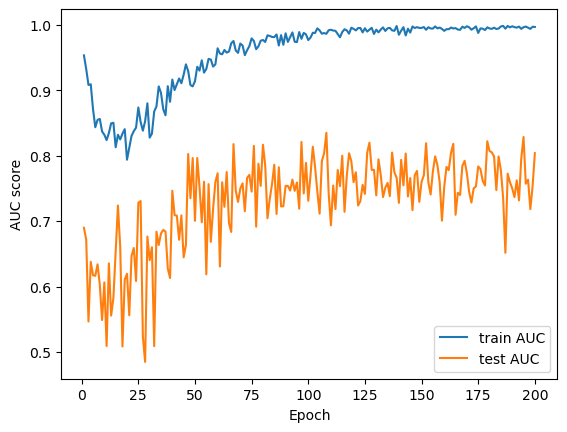

In [31]:
best_auc = 0
best_acc = 0
best_epoch = 0
patience = 5
stop_counter = 0

train_auc_scores = []
test_auc_scores = []
epochs = []

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    train_loss = 0
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        targets = targets.squeeze().long()
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        optimizer.step()

    # Evaluate after each epoch
    print(f"==> Evaluating after epoch {epoch + 1} ...")
    train_metrics = evaluate(train_loader)
    test_metrics = evaluate(test_loader)
    
    print(f"Train AUC: {train_metrics[0]}, Train ACC: {train_metrics[1]}")
    print(f"Test AUC: {test_metrics[0]}, Test ACC: {test_metrics[1]}")

    # Check if AUC score improved
    if test_metrics[0] > best_auc:
        best_auc = test_metrics[0]
        best_acc = test_metrics[1]
        best_epoch = epoch + 1
        print(f"==> Best test AUC and ACC score updated: {best_auc:.4f}, {best_acc:.4f}")
        # Save the model state
        torch.save(model.state_dict(), 'best_model_breastmnist.pth')
    #     stop_counter = 0
    # else:
    #     stop_counter += 1

    # Append AUC scores and epoch numbers
    train_auc_scores.append(train_metrics[0])
    test_auc_scores.append(test_metrics[0])
    epochs.append(epoch+1)

    # Check for early stopping
    # if stop_counter >= patience:
    #     print("Early stopping triggered")
    #     break

print(f"Best test AUC: {best_auc:.4f} and ACC: {best_acc:.4f} achieved at epoch {best_epoch}")

# Plot the train and test AUC scores vs epoch
plt.plot(epochs, train_auc_scores, label='train AUC')
plt.plot(epochs, test_auc_scores, label='test AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC score')
plt.show()

## ResNet18 without dropout

In [32]:
model.load_state_dict(torch.load("best_pretraind_model_breastmnist.pth"))

<All keys matched successfully>

In [33]:
SEED = 123
BATCH_SIZE = 128
lr = 0.001 # using smaller learning rate is better
epoch_decay = 2e-3
weight_decay = 1e-5
margin = 1.0

In [34]:
# define loss & optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model, 
                 loss_fn=loss_fn, 
                 lr=lr, 
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)

100%|██████████| 9/9 [00:00<00:00, 13.49it/s]


==> Evaluating after epoch 1 ...
Train AUC: 0.9580753648218424, Train ACC: 39.64102564102564
Test AUC: 0.7057055080096555, Test ACC: 72.0
==> Best test AUC and ACC score updated: 0.7057, 72.0000


100%|██████████| 9/9 [00:00<00:00, 24.23it/s]


==> Evaluating after epoch 2 ...
Train AUC: 0.9394203365197112, Train ACC: 39.014652014652015
Test AUC: 0.6972789115646258, Test ACC: 71.82051282051282


100%|██████████| 9/9 [00:00<00:00, 25.31it/s]


==> Evaluating after epoch 3 ...
Train AUC: 0.918144544681716, Train ACC: 37.934065934065934
Test AUC: 0.698200570550801, Test ACC: 70.14102564102564


100%|██████████| 9/9 [00:00<00:00, 24.96it/s]


==> Evaluating after epoch 4 ...
Train AUC: 0.8906775160869468, Train ACC: 36.45054945054945
Test AUC: 0.6872942725477288, Test ACC: 65.32051282051282


100%|██████████| 9/9 [00:00<00:00, 25.56it/s]


==> Evaluating after epoch 5 ...
Train AUC: 0.9024394397319759, Train ACC: 36.311355311355314
Test AUC: 0.6479921000658329, Test ACC: 63.743589743589745


100%|██████████| 9/9 [00:00<00:00, 25.74it/s]


==> Evaluating after epoch 6 ...
Train AUC: 0.8567794055081737, Train ACC: 35.223443223443226
Test AUC: 0.5942286592056177, Test ACC: 61.69230769230769


100%|██████████| 9/9 [00:00<00:00, 25.52it/s]


==> Evaluating after epoch 7 ...
Train AUC: 0.8048157746739769, Train ACC: 35.35897435897436
Test AUC: 0.5584814570989686, Test ACC: 63.65384615384615


100%|██████████| 9/9 [00:00<00:00, 24.84it/s]


==> Evaluating after epoch 8 ...
Train AUC: 0.8602303852534497, Train ACC: 35.65934065934066
Test AUC: 0.6822470923853412, Test ACC: 61.51282051282051


100%|██████████| 9/9 [00:00<00:00, 24.93it/s]


==> Evaluating after epoch 9 ...
Train AUC: 0.8768931777818971, Train ACC: 34.58974358974359
Test AUC: 0.607417160412552, Test ACC: 61.333333333333336


100%|██████████| 9/9 [00:00<00:00, 25.29it/s]


==> Evaluating after epoch 10 ...
Train AUC: 0.8660995902033579, Train ACC: 34.78021978021978
Test AUC: 0.7045205178845733, Test ACC: 60.03846153846154


100%|██████████| 9/9 [00:00<00:00, 24.65it/s]


==> Evaluating after epoch 11 ...
Train AUC: 0.8005569154626251, Train ACC: 34.88644688644688
Test AUC: 0.5842659644502963, Test ACC: 60.205128205128204


100%|██████████| 9/9 [00:00<00:00, 25.37it/s]


==> Evaluating after epoch 12 ...
Train AUC: 0.8093784718155078, Train ACC: 36.223443223443226
Test AUC: 0.6507790212859337, Test ACC: 58.53846153846154


100%|██████████| 9/9 [00:00<00:00, 23.98it/s]


==> Evaluating after epoch 13 ...
Train AUC: 0.8257940879188291, Train ACC: 35.391941391941394
Test AUC: 0.5511959622558701, Test ACC: 61.15384615384615


100%|██████████| 9/9 [00:00<00:00, 23.46it/s]


==> Evaluating after epoch 14 ...
Train AUC: 0.8290219735001505, Train ACC: 33.67032967032967
Test AUC: 0.530787798990564, Test ACC: 59.37179487179487


100%|██████████| 9/9 [00:00<00:00, 24.43it/s]


==> Evaluating after epoch 15 ...
Train AUC: 0.8175900098333906, Train ACC: 34.637362637362635
Test AUC: 0.7006583278472679, Test ACC: 60.12820512820513


100%|██████████| 9/9 [00:00<00:00, 25.93it/s]


==> Evaluating after epoch 16 ...
Train AUC: 0.8676681497934404, Train ACC: 34.666666666666664
Test AUC: 0.6364494184770683, Test ACC: 60.12820512820513


100%|██████████| 9/9 [00:00<00:00, 25.07it/s]


==> Evaluating after epoch 17 ...
Train AUC: 0.794667235022501, Train ACC: 34.1025641025641
Test AUC: 0.6011191573403556, Test ACC: 59.3974358974359


100%|██████████| 9/9 [00:00<00:00, 25.30it/s]


==> Evaluating after epoch 18 ...
Train AUC: 0.7939773466852706, Train ACC: 34.32967032967033
Test AUC: 0.6094360324775071, Test ACC: 60.666666666666664


100%|██████████| 9/9 [00:00<00:00, 24.96it/s]


==> Evaluating after epoch 19 ...
Train AUC: 0.8108135697018723, Train ACC: 35.142857142857146
Test AUC: 0.6027649769585253, Test ACC: 61.42307692307692


100%|██████████| 9/9 [00:00<00:00, 25.08it/s]


==> Evaluating after epoch 20 ...
Train AUC: 0.8141374875597457, Train ACC: 34.61538461538461
Test AUC: 0.6514592933947772, Test ACC: 58.53846153846154


100%|██████████| 9/9 [00:00<00:00, 25.00it/s]


==> Evaluating after epoch 21 ...
Train AUC: 0.8454014942055393, Train ACC: 31.90842490842491
Test AUC: 0.717357910906298, Test ACC: 55.67948717948718
==> Best test AUC and ACC score updated: 0.7174, 55.6795


100%|██████████| 9/9 [00:00<00:00, 25.27it/s]


==> Evaluating after epoch 22 ...
Train AUC: 0.8517740643215256, Train ACC: 32.688644688644686
Test AUC: 0.6434057493965328, Test ACC: 52.243589743589745


100%|██████████| 9/9 [00:00<00:00, 25.16it/s]


==> Evaluating after epoch 23 ...
Train AUC: 0.8319693413465744, Train ACC: 32.93040293040293
Test AUC: 0.6263989466754444, Test ACC: 56.97435897435897


100%|██████████| 9/9 [00:00<00:00, 24.00it/s]


==> Evaluating after epoch 24 ...
Train AUC: 0.8430895573590226, Train ACC: 33.175824175824175
Test AUC: 0.743734913320167, Test ACC: 55.294871794871796
==> Best test AUC and ACC score updated: 0.7437, 55.2949


100%|██████████| 9/9 [00:00<00:00, 23.86it/s]


==> Evaluating after epoch 25 ...
Train AUC: 0.8441301569893196, Train ACC: 32.146520146520146
Test AUC: 0.579964889181479, Test ACC: 58.55128205128205


100%|██████████| 9/9 [00:00<00:00, 24.41it/s]


==> Evaluating after epoch 26 ...
Train AUC: 0.8266657082548162, Train ACC: 33.2967032967033
Test AUC: 0.6320605661619487, Test ACC: 55.76923076923077


100%|██████████| 9/9 [00:00<00:00, 25.37it/s]


==> Evaluating after epoch 27 ...
Train AUC: 0.8312611394442042, Train ACC: 33.23076923076923
Test AUC: 0.6646916831248628, Test ACC: 58.55128205128205


100%|██████████| 9/9 [00:00<00:00, 24.35it/s]


==> Evaluating after epoch 28 ...
Train AUC: 0.8462364012960935, Train ACC: 32.93040293040293
Test AUC: 0.6931314461268379, Test ACC: 54.93589743589744


100%|██████████| 9/9 [00:00<00:00, 25.33it/s]


==> Evaluating after epoch 29 ...
Train AUC: 0.851150003214083, Train ACC: 32.88644688644688
Test AUC: 0.6890059249506255, Test ACC: 57.8974358974359


100%|██████████| 9/9 [00:00<00:00, 25.11it/s]


==> Evaluating after epoch 30 ...
Train AUC: 0.869608883029358, Train ACC: 33.124542124542124
Test AUC: 0.7517006802721089, Test ACC: 56.42307692307692
==> Best test AUC and ACC score updated: 0.7517, 56.4231


100%|██████████| 9/9 [00:00<00:00, 25.00it/s]


==> Evaluating after epoch 31 ...
Train AUC: 0.8714084220253755, Train ACC: 34.54578754578755
Test AUC: 0.7075049374588546, Test ACC: 60.02564102564103


100%|██████████| 9/9 [00:00<00:00, 25.08it/s]


==> Evaluating after epoch 32 ...
Train AUC: 0.8958466614765259, Train ACC: 32.904761904761905
Test AUC: 0.670024138687733, Test ACC: 56.217948717948715


100%|██████████| 9/9 [00:00<00:00, 25.70it/s]


==> Evaluating after epoch 33 ...
Train AUC: 0.8867162097818793, Train ACC: 33.63003663003663
Test AUC: 0.6125082290980908, Test ACC: 56.782051282051285


100%|██████████| 9/9 [00:00<00:00, 23.97it/s]


==> Evaluating after epoch 34 ...
Train AUC: 0.8758723553037445, Train ACC: 33.747252747252745
Test AUC: 0.6426157559798114, Test ACC: 58.64102564102564


100%|██████████| 9/9 [00:00<00:00, 23.86it/s]


==> Evaluating after epoch 35 ...
Train AUC: 0.9135430788511764, Train ACC: 32.315018315018314
Test AUC: 0.6864384463462805, Test ACC: 57.794871794871796


100%|██████████| 9/9 [00:00<00:00, 22.97it/s]


==> Evaluating after epoch 36 ...
Train AUC: 0.8801358348931726, Train ACC: 34.38095238095238
Test AUC: 0.6280886548167655, Test ACC: 56.23076923076923


100%|██████████| 9/9 [00:00<00:00, 23.68it/s]


==> Evaluating after epoch 37 ...
Train AUC: 0.8872327233948849, Train ACC: 32.417582417582416
Test AUC: 0.7411674347158218, Test ACC: 60.96153846153846


100%|██████████| 9/9 [00:00<00:00, 24.32it/s]


==> Evaluating after epoch 38 ...
Train AUC: 0.9036875142604308, Train ACC: 32.523809523809526
Test AUC: 0.6842220759271451, Test ACC: 56.61538461538461


100%|██████████| 9/9 [00:00<00:00, 24.37it/s]


==> Evaluating after epoch 39 ...
Train AUC: 0.9147413618887891, Train ACC: 32.26373626373626
Test AUC: 0.6624533684441518, Test ACC: 58.73076923076923


100%|██████████| 9/9 [00:00<00:00, 21.99it/s]


==> Evaluating after epoch 40 ...
Train AUC: 0.917053737768347, Train ACC: 32.38461538461539
Test AUC: 0.683190695633092, Test ACC: 58.46153846153846


100%|██████████| 9/9 [00:00<00:00, 25.07it/s]


==> Evaluating after epoch 41 ...
Train AUC: 0.9134720123424049, Train ACC: 32.062271062271066
Test AUC: 0.7168531928900592, Test ACC: 58.64102564102564


100%|██████████| 9/9 [00:00<00:00, 23.80it/s]


==> Evaluating after epoch 42 ...
Train AUC: 0.9154430279415815, Train ACC: 32.83882783882784
Test AUC: 0.7111037963572526, Test ACC: 59.01282051282051


100%|██████████| 9/9 [00:00<00:00, 24.35it/s]


==> Evaluating after epoch 43 ...
Train AUC: 0.8988804174150131, Train ACC: 32.18681318681319
Test AUC: 0.6778143515470705, Test ACC: 56.41025641025641


100%|██████████| 9/9 [00:00<00:00, 24.10it/s]


==> Evaluating after epoch 44 ...
Train AUC: 0.902427515338621, Train ACC: 32.56043956043956
Test AUC: 0.7114329602808864, Test ACC: 57.98717948717949


100%|██████████| 9/9 [00:00<00:00, 24.06it/s]


==> Evaluating after epoch 45 ...
Train AUC: 0.9246784258775718, Train ACC: 31.395604395604394
Test AUC: 0.7347377660741716, Test ACC: 57.61538461538461


100%|██████████| 9/9 [00:00<00:00, 24.40it/s]


==> Evaluating after epoch 46 ...
Train AUC: 0.9381618078871065, Train ACC: 32.71062271062271
Test AUC: 0.7950625411454904, Test ACC: 56.23076923076923
==> Best test AUC and ACC score updated: 0.7951, 56.2308


100%|██████████| 9/9 [00:00<00:00, 20.55it/s]


==> Evaluating after epoch 47 ...
Train AUC: 0.9372024487437497, Train ACC: 33.42490842490842
Test AUC: 0.7002852754004827, Test ACC: 55.38461538461539


100%|██████████| 9/9 [00:00<00:00, 23.19it/s]


==> Evaluating after epoch 48 ...
Train AUC: 0.9475629260875534, Train ACC: 32.985347985347985
Test AUC: 0.7457537853851217, Test ACC: 53.98717948717949


100%|██████████| 9/9 [00:00<00:00, 23.91it/s]


==> Evaluating after epoch 49 ...
Train AUC: 0.9251770798782195, Train ACC: 33.040293040293044
Test AUC: 0.7166118060127276, Test ACC: 54.282051282051285


100%|██████████| 9/9 [00:00<00:00, 23.17it/s]


==> Evaluating after epoch 50 ...
Train AUC: 0.9270572076724195, Train ACC: 32.989010989010985
Test AUC: 0.676695194206715, Test ACC: 58.833333333333336


100%|██████████| 9/9 [00:00<00:00, 23.55it/s]


==> Evaluating after epoch 51 ...
Train AUC: 0.943167882735374, Train ACC: 32.91208791208791
Test AUC: 0.7513495720868992, Test ACC: 56.5


100%|██████████| 9/9 [00:00<00:00, 25.06it/s]


==> Evaluating after epoch 52 ...
Train AUC: 0.9306458535375138, Train ACC: 31.593406593406595
Test AUC: 0.7489137590520079, Test ACC: 56.243589743589745


100%|██████████| 9/9 [00:00<00:00, 24.48it/s]


==> Evaluating after epoch 53 ...
Train AUC: 0.9131174867974882, Train ACC: 33.38827838827839
Test AUC: 0.7906956330919465, Test ACC: 55.94871794871795


100%|██████████| 9/9 [00:00<00:00, 23.43it/s]


==> Evaluating after epoch 54 ...
Train AUC: 0.9279806503530913, Train ACC: 32.67399267399267
Test AUC: 0.6551020408163266, Test ACC: 53.07692307692308


100%|██████████| 9/9 [00:00<00:00, 23.59it/s]


==> Evaluating after epoch 55 ...
Train AUC: 0.9613759252379999, Train ACC: 32.336996336996336
Test AUC: 0.7021944261575598, Test ACC: 54.64102564102564


100%|██████████| 9/9 [00:00<00:00, 24.26it/s]


==> Evaluating after epoch 56 ...
Train AUC: 0.9541932535284123, Train ACC: 32.37728937728938
Test AUC: 0.7355277594908931, Test ACC: 55.57692307692308


100%|██████████| 9/9 [00:00<00:00, 22.01it/s]


==> Evaluating after epoch 57 ...
Train AUC: 0.944569605617753, Train ACC: 32.56410256410256
Test AUC: 0.7186306780776827, Test ACC: 58.166666666666664


100%|██████████| 9/9 [00:00<00:00, 23.30it/s]


==> Evaluating after epoch 58 ...
Train AUC: 0.9550624760638615, Train ACC: 32.1978021978022
Test AUC: 0.7839148562650866, Test ACC: 55.666666666666664


100%|██████████| 9/9 [00:00<00:00, 22.12it/s]


==> Evaluating after epoch 59 ...
Train AUC: 0.9527296974728442, Train ACC: 32.21611721611722
Test AUC: 0.784441518542901, Test ACC: 52.42307692307692


100%|██████████| 9/9 [00:00<00:00, 23.05it/s]


==> Evaluating after epoch 60 ...
Train AUC: 0.9402996723528676, Train ACC: 33.494505494505496
Test AUC: 0.6971691902567478, Test ACC: 55.02564102564103


100%|██████████| 9/9 [00:00<00:00, 24.46it/s]


==> Evaluating after epoch 61 ...
Train AUC: 0.9699379304378994, Train ACC: 31.72893772893773
Test AUC: 0.6722843976300197, Test ACC: 55.96153846153846


100%|██████████| 9/9 [00:00<00:00, 24.52it/s]


==> Evaluating after epoch 62 ...
Train AUC: 0.96977610485044, Train ACC: 32.70695970695971
Test AUC: 0.7746324336186088, Test ACC: 49.717948717948715


100%|██████████| 9/9 [00:00<00:00, 25.23it/s]


==> Evaluating after epoch 63 ...
Train AUC: 0.9674394172207391, Train ACC: 31.87912087912088
Test AUC: 0.7847926267281107, Test ACC: 53.53846153846154


100%|██████████| 9/9 [00:00<00:00, 24.95it/s]


==> Evaluating after epoch 64 ...
Train AUC: 0.9723245587948414, Train ACC: 33.03663003663004
Test AUC: 0.6892912003511082, Test ACC: 53.53846153846154


100%|██████████| 9/9 [00:00<00:00, 25.08it/s]


==> Evaluating after epoch 65 ...
Train AUC: 0.9664909726567922, Train ACC: 30.985347985347985
Test AUC: 0.7889620364274742, Test ACC: 55.294871794871796


100%|██████████| 9/9 [00:00<00:00, 24.57it/s]


==> Evaluating after epoch 66 ...
Train AUC: 0.962071351900382, Train ACC: 31.915750915750916
Test AUC: 0.743559359227562, Test ACC: 57.06410256410256


100%|██████████| 9/9 [00:00<00:00, 24.46it/s]


==> Evaluating after epoch 67 ...
Train AUC: 0.9776357804657587, Train ACC: 32.095238095238095
Test AUC: 0.7794821154268159, Test ACC: 54.92307692307692


100%|██████████| 9/9 [00:00<00:00, 24.93it/s]


==> Evaluating after epoch 68 ...
Train AUC: 0.9675311852876651, Train ACC: 31.113553113553113
Test AUC: 0.7563089752029845, Test ACC: 56.794871794871796


100%|██████████| 9/9 [00:00<00:00, 24.18it/s]


==> Evaluating after epoch 69 ...
Train AUC: 0.9744013120552872, Train ACC: 33.05128205128205
Test AUC: 0.7061224489795919, Test ACC: 59.38461538461539


100%|██████████| 9/9 [00:00<00:00, 21.31it/s]


==> Evaluating after epoch 70 ...
Train AUC: 0.9639871751849728, Train ACC: 31.9010989010989
Test AUC: 0.7645819618169849, Test ACC: 56.32051282051282


100%|██████████| 9/9 [00:00<00:00, 21.59it/s]


==> Evaluating after epoch 71 ...
Train AUC: 0.9714006290979975, Train ACC: 31.42124542124542
Test AUC: 0.73963133640553, Test ACC: 56.14102564102564


100%|██████████| 9/9 [00:00<00:00, 22.32it/s]


==> Evaluating after epoch 72 ...
Train AUC: 0.965510190414315, Train ACC: 32.091575091575095
Test AUC: 0.7473337722185648, Test ACC: 55.67948717948718


100%|██████████| 9/9 [00:00<00:00, 23.97it/s]


==> Evaluating after epoch 73 ...
Train AUC: 0.9811412037990846, Train ACC: 32.94871794871795
Test AUC: 0.7578889620364274, Test ACC: 54.55128205128205


100%|██████████| 9/9 [00:00<00:00, 22.59it/s]


==> Evaluating after epoch 74 ...
Train AUC: 0.9746085286209776, Train ACC: 31.91941391941392
Test AUC: 0.7390388413429887, Test ACC: 55.294871794871796


100%|██████████| 9/9 [00:00<00:00, 23.12it/s]


==> Evaluating after epoch 75 ...
Train AUC: 0.965786753872024, Train ACC: 31.512820512820515
Test AUC: 0.751086240947992, Test ACC: 54.64102564102564


100%|██████████| 9/9 [00:00<00:00, 23.80it/s]


==> Evaluating after epoch 76 ...
Train AUC: 0.9737793571366231, Train ACC: 30.937728937728938
Test AUC: 0.7227123107307438, Test ACC: 54.1025641025641


100%|██████████| 9/9 [00:00<00:00, 23.35it/s]


==> Evaluating after epoch 77 ...
Train AUC: 0.9689103264281531, Train ACC: 31.673992673992675
Test AUC: 0.7273206056616195, Test ACC: 55.205128205128204


100%|██████████| 9/9 [00:00<00:00, 25.07it/s]


==> Evaluating after epoch 78 ...
Train AUC: 0.9788404306715791, Train ACC: 32.095238095238095
Test AUC: 0.7742593811718235, Test ACC: 56.782051282051285


100%|██████████| 9/9 [00:00<00:00, 23.29it/s]


==> Evaluating after epoch 79 ...
Train AUC: 0.9754826649385606, Train ACC: 31.86813186813187
Test AUC: 0.7059907834101382, Test ACC: 54.55128205128205


100%|██████████| 9/9 [00:00<00:00, 24.75it/s]


==> Evaluating after epoch 80 ...
Train AUC: 0.9742816654595532, Train ACC: 32.99633699633699
Test AUC: 0.7675005486065394, Test ACC: 59.11538461538461


100%|██████████| 9/9 [00:00<00:00, 22.32it/s]


==> Evaluating after epoch 81 ...
Train AUC: 0.9668442625781045, Train ACC: 32.772893772893774
Test AUC: 0.7807109940750494, Test ACC: 56.03846153846154


100%|██████████| 9/9 [00:00<00:00, 24.08it/s]


==> Evaluating after epoch 82 ...
Train AUC: 0.9706191461274492, Train ACC: 31.63736263736264
Test AUC: 0.7520956769804696, Test ACC: 51.76923076923077


100%|██████████| 9/9 [00:00<00:00, 24.67it/s]


==> Evaluating after epoch 83 ...
Train AUC: 0.980624716136695, Train ACC: 32.07326007326007
Test AUC: 0.7421110379635725, Test ACC: 55.87179487179487


100%|██████████| 9/9 [00:00<00:00, 24.80it/s]


==> Evaluating after epoch 84 ...
Train AUC: 0.9779305600715619, Train ACC: 32.498168498168496
Test AUC: 0.831819179284617, Test ACC: 55.84615384615385
==> Best test AUC and ACC score updated: 0.8318, 55.8462


100%|██████████| 9/9 [00:00<00:00, 24.55it/s]


==> Evaluating after epoch 85 ...
Train AUC: 0.9771194246148076, Train ACC: 31.82783882783883
Test AUC: 0.7582400702216371, Test ACC: 56.58974358974359


100%|██████████| 9/9 [00:00<00:00, 25.38it/s]


==> Evaluating after epoch 86 ...
Train AUC: 0.9739163039483967, Train ACC: 31.194139194139193
Test AUC: 0.711301294711433, Test ACC: 54.65384615384615


100%|██████████| 9/9 [00:00<00:00, 25.00it/s]


==> Evaluating after epoch 87 ...
Train AUC: 0.9894926609819821, Train ACC: 31.725274725274726
Test AUC: 0.827781435154707, Test ACC: 59.205128205128204


100%|██████████| 9/9 [00:00<00:00, 23.12it/s]


==> Evaluating after epoch 88 ...
Train AUC: 0.9797219981362946, Train ACC: 33.1978021978022
Test AUC: 0.7751590958964231, Test ACC: 59.01282051282051


100%|██████████| 9/9 [00:00<00:00, 24.98it/s]


==> Evaluating after epoch 89 ...
Train AUC: 0.9776986704129301, Train ACC: 32.46153846153846
Test AUC: 0.7541584375685758, Test ACC: 54.92307692307692


100%|██████████| 9/9 [00:00<00:00, 24.79it/s]


==> Evaluating after epoch 90 ...
Train AUC: 0.9832779743118435, Train ACC: 32.23809523809524
Test AUC: 0.7434057493965328, Test ACC: 53.35897435897436


100%|██████████| 9/9 [00:00<00:00, 24.72it/s]


==> Evaluating after epoch 91 ...
Train AUC: 0.9801910125714435, Train ACC: 31.72893772893773
Test AUC: 0.8188062321702874, Test ACC: 55.02564102564103


100%|██████████| 9/9 [00:00<00:00, 24.95it/s]


==> Evaluating after epoch 92 ...
Train AUC: 0.9864286997980742, Train ACC: 32.010989010989015
Test AUC: 0.7664252797893351, Test ACC: 52.32051282051282


100%|██████████| 9/9 [00:00<00:00, 25.33it/s]


==> Evaluating after epoch 93 ...
Train AUC: 0.9822789264896343, Train ACC: 32.75457875457875
Test AUC: 0.7350010972130787, Test ACC: 54.833333333333336


100%|██████████| 9/9 [00:00<00:00, 24.98it/s]


==> Evaluating after epoch 94 ...
Train AUC: 0.9831076726654396, Train ACC: 32.37728937728938
Test AUC: 0.7897300855826201, Test ACC: 52.6025641025641


100%|██████████| 9/9 [00:00<00:00, 25.08it/s]


==> Evaluating after epoch 95 ...
Train AUC: 0.9909762198391101, Train ACC: 32.05494505494506
Test AUC: 0.793285055957867, Test ACC: 55.85897435897436


100%|██████████| 9/9 [00:00<00:00, 23.27it/s]


==> Evaluating after epoch 96 ...
Train AUC: 0.9915620861881127, Train ACC: 33.16117216117216
Test AUC: 0.7708799648891815, Test ACC: 53.62820512820513


100%|██████████| 9/9 [00:00<00:00, 24.11it/s]


==> Evaluating after epoch 97 ...
Train AUC: 0.9795436403912539, Train ACC: 31.835164835164836
Test AUC: 0.7331138907175774, Test ACC: 54.19230769230769


100%|██████████| 9/9 [00:00<00:00, 25.21it/s]


==> Evaluating after epoch 98 ...
Train AUC: 0.9895581241641133, Train ACC: 30.55677655677656
Test AUC: 0.7574281325433398, Test ACC: 54.0


100%|██████████| 9/9 [00:00<00:00, 24.47it/s]


==> Evaluating after epoch 99 ...
Train AUC: 0.9860917569846266, Train ACC: 30.61904761904762
Test AUC: 0.7630678077682685, Test ACC: 54.833333333333336


100%|██████████| 9/9 [00:00<00:00, 23.91it/s]


==> Evaluating after epoch 100 ...
Train AUC: 0.9924452119255373, Train ACC: 31.16117216117216
Test AUC: 0.769431643625192, Test ACC: 53.61538461538461


100%|██████████| 9/9 [00:00<00:00, 24.46it/s]


==> Evaluating after epoch 101 ...
Train AUC: 0.9866805656969085, Train ACC: 30.3003663003663
Test AUC: 0.7640772438007462, Test ACC: 53.62820512820513


100%|██████████| 9/9 [00:00<00:00, 23.56it/s]


==> Evaluating after epoch 102 ...
Train AUC: 0.9819527722735756, Train ACC: 32.443223443223445
Test AUC: 0.7937019969278034, Test ACC: 59.1025641025641


100%|██████████| 9/9 [00:00<00:00, 23.48it/s]


==> Evaluating after epoch 103 ...
Train AUC: 0.9878552153526109, Train ACC: 32.91208791208791
Test AUC: 0.7963791968400262, Test ACC: 52.30769230769231


100%|██████████| 9/9 [00:00<00:00, 23.52it/s]


==> Evaluating after epoch 104 ...
Train AUC: 0.9903119672985744, Train ACC: 34.00366300366301
Test AUC: 0.72642089093702, Test ACC: 55.57692307692308


100%|██████████| 9/9 [00:00<00:00, 24.07it/s]


==> Evaluating after epoch 105 ...
Train AUC: 0.9897370474599838, Train ACC: 33.26007326007326
Test AUC: 0.7601711652402896, Test ACC: 60.03846153846154


100%|██████████| 9/9 [00:00<00:00, 25.53it/s]


==> Evaluating after epoch 106 ...
Train AUC: 0.9886186084022426, Train ACC: 31.794871794871796
Test AUC: 0.6904103576914637, Test ACC: 55.67948717948718


100%|██████████| 9/9 [00:00<00:00, 25.33it/s]


==> Evaluating after epoch 107 ...
Train AUC: 0.9901967733166723, Train ACC: 31.406593406593405
Test AUC: 0.7689488698705289, Test ACC: 57.80769230769231


100%|██████████| 9/9 [00:00<00:00, 24.83it/s]


==> Evaluating after epoch 108 ...
Train AUC: 0.9930042403419022, Train ACC: 32.35897435897436
Test AUC: 0.7852973447443494, Test ACC: 55.294871794871796


100%|██████████| 9/9 [00:00<00:00, 25.05it/s]


==> Evaluating after epoch 109 ...
Train AUC: 0.9930370284504701, Train ACC: 31.78754578754579
Test AUC: 0.7774193548387096, Test ACC: 55.02564102564103


100%|██████████| 9/9 [00:00<00:00, 24.33it/s]


==> Evaluating after epoch 110 ...
Train AUC: 0.9801776088240138, Train ACC: 32.54212454212454
Test AUC: 0.7793943383805135, Test ACC: 55.96153846153846


100%|██████████| 9/9 [00:00<00:00, 23.85it/s]


==> Evaluating after epoch 111 ...
Train AUC: 0.9909085867274826, Train ACC: 31.765567765567766
Test AUC: 0.7939872723282861, Test ACC: 56.97435897435897


100%|██████████| 9/9 [00:00<00:00, 25.14it/s]


==> Evaluating after epoch 112 ...
Train AUC: 0.9889415199453373, Train ACC: 31.875457875457876
Test AUC: 0.7917709019091508, Test ACC: 55.48717948717949


100%|██████████| 9/9 [00:00<00:00, 25.46it/s]


==> Evaluating after epoch 113 ...
Train AUC: 0.9942151922135241, Train ACC: 32.527472527472526
Test AUC: 0.797651964011411, Test ACC: 53.717948717948715


100%|██████████| 9/9 [00:00<00:00, 24.83it/s]


==> Evaluating after epoch 114 ...
Train AUC: 0.9864819306171125, Train ACC: 31.761904761904763
Test AUC: 0.7900811937678297, Test ACC: 56.6025641025641


100%|██████████| 9/9 [00:00<00:00, 24.64it/s]


==> Evaluating after epoch 115 ...
Train AUC: 0.9937824771315338, Train ACC: 32.23076923076923
Test AUC: 0.7796576695194206, Test ACC: 58.53846153846154


100%|██████████| 9/9 [00:00<00:00, 24.75it/s]


==> Evaluating after epoch 116 ...
Train AUC: 0.9879139112683331, Train ACC: 32.684981684981686
Test AUC: 0.8152293175334651, Test ACC: 55.65384615384615


100%|██████████| 9/9 [00:00<00:00, 24.98it/s]


==> Evaluating after epoch 117 ...
Train AUC: 0.9953763459574864, Train ACC: 32.81318681318681
Test AUC: 0.8177529076146588, Test ACC: 56.88461538461539


100%|██████████| 9/9 [00:00<00:00, 24.84it/s]


==> Evaluating after epoch 118 ...
Train AUC: 0.9866884061515461, Train ACC: 32.57875457875458
Test AUC: 0.8498793065613341, Test ACC: 57.166666666666664
==> Best test AUC and ACC score updated: 0.8499, 57.1667


100%|██████████| 9/9 [00:00<00:00, 25.05it/s]


==> Evaluating after epoch 119 ...
Train AUC: 0.9889145013736128, Train ACC: 31.168498168498168
Test AUC: 0.8031380294053105, Test ACC: 56.3974358974359


100%|██████████| 9/9 [00:00<00:00, 25.04it/s]


==> Evaluating after epoch 120 ...
Train AUC: 0.9949614586614663, Train ACC: 32.51282051282051
Test AUC: 0.785582620144832, Test ACC: 58.37179487179487


100%|██████████| 9/9 [00:00<00:00, 24.32it/s]


==> Evaluating after epoch 121 ...
Train AUC: 0.9902608369961534, Train ACC: 31.02930402930403
Test AUC: 0.7473776607417161, Test ACC: 55.217948717948715


100%|██████████| 9/9 [00:00<00:00, 23.77it/s]


==> Evaluating after epoch 122 ...
Train AUC: 0.9923310321970066, Train ACC: 31.435897435897434
Test AUC: 0.7885450954575379, Test ACC: 58.92307692307692


100%|██████████| 9/9 [00:00<00:00, 24.57it/s]


==> Evaluating after epoch 123 ...
Train AUC: 0.9932809074610126, Train ACC: 32.8058608058608
Test AUC: 0.8107307439104674, Test ACC: 55.47435897435897


100%|██████████| 9/9 [00:00<00:00, 24.54it/s]


==> Evaluating after epoch 124 ...
Train AUC: 0.9927537572012758, Train ACC: 32.23809523809524
Test AUC: 0.7905420232609173, Test ACC: 57.34615384615385


100%|██████████| 9/9 [00:00<00:00, 23.54it/s]


==> Evaluating after epoch 125 ...
Train AUC: 0.994546146768428, Train ACC: 31.64835164835165
Test AUC: 0.7937458854509546, Test ACC: 57.43589743589744


100%|██████████| 9/9 [00:00<00:00, 23.70it/s]


==> Evaluating after epoch 126 ...
Train AUC: 0.9934125946250477, Train ACC: 32.20879120879121
Test AUC: 0.8183234584156244, Test ACC: 56.88461538461539


100%|██████████| 9/9 [00:00<00:00, 23.59it/s]


==> Evaluating after epoch 127 ...
Train AUC: 0.9935130623983637, Train ACC: 32.1025641025641
Test AUC: 0.7695194206714944, Test ACC: 62.43589743589744


100%|██████████| 9/9 [00:00<00:00, 24.37it/s]


==> Evaluating after epoch 128 ...
Train AUC: 0.9951922835873757, Train ACC: 33.54578754578755
Test AUC: 0.8171165240289664, Test ACC: 59.02564102564103


100%|██████████| 9/9 [00:00<00:00, 24.77it/s]


==> Evaluating after epoch 129 ...
Train AUC: 0.9927106212362106, Train ACC: 31.564102564102566
Test AUC: 0.7935483870967741, Test ACC: 50.84615384615385


100%|██████████| 9/9 [00:00<00:00, 25.41it/s]


==> Evaluating after epoch 130 ...
Train AUC: 0.9903837681490377, Train ACC: 31.76923076923077
Test AUC: 0.8010094360324775, Test ACC: 53.256410256410255


100%|██████████| 9/9 [00:00<00:00, 24.23it/s]


==> Evaluating after epoch 131 ...
Train AUC: 0.9943262484764964, Train ACC: 31.479853479853478
Test AUC: 0.8154707044107966, Test ACC: 53.82051282051282


100%|██████████| 9/9 [00:00<00:00, 24.93it/s]


==> Evaluating after epoch 132 ...
Train AUC: 0.9874224600438216, Train ACC: 31.564102564102566
Test AUC: 0.8150976519640114, Test ACC: 56.51282051282051


100%|██████████| 9/9 [00:00<00:00, 24.73it/s]


==> Evaluating after epoch 133 ...
Train AUC: 0.9921987898025786, Train ACC: 31.168498168498168
Test AUC: 0.773469387755102, Test ACC: 58.08974358974359


100%|██████████| 9/9 [00:00<00:00, 24.05it/s]


==> Evaluating after epoch 134 ...
Train AUC: 0.9925689832931592, Train ACC: 31.78754578754579
Test AUC: 0.8484529295589204, Test ACC: 50.1025641025641


100%|██████████| 9/9 [00:00<00:00, 25.25it/s]


==> Evaluating after epoch 135 ...
Train AUC: 0.994089861919908, Train ACC: 31.604395604395606
Test AUC: 0.7721088435374149, Test ACC: 53.73076923076923


100%|██████████| 9/9 [00:00<00:00, 24.68it/s]


==> Evaluating after epoch 136 ...
Train AUC: 0.995062483905648, Train ACC: 32.45787545787546
Test AUC: 0.7667983322361203, Test ACC: 56.87179487179487


100%|██████████| 9/9 [00:00<00:00, 25.14it/s]


==> Evaluating after epoch 137 ...
Train AUC: 0.9955756389579918, Train ACC: 32.556776556776555
Test AUC: 0.7818959842001316, Test ACC: 56.97435897435897


100%|██████████| 9/9 [00:00<00:00, 24.43it/s]


==> Evaluating after epoch 138 ...
Train AUC: 0.9961116830215165, Train ACC: 32.252747252747255
Test AUC: 0.7991661180601273, Test ACC: 55.1025641025641


100%|██████████| 9/9 [00:00<00:00, 25.31it/s]


==> Evaluating after epoch 139 ...
Train AUC: 0.9964896415918171, Train ACC: 31.494505494505493
Test AUC: 0.7806451612903226, Test ACC: 55.12820512820513


100%|██████████| 9/9 [00:00<00:00, 25.08it/s]


==> Evaluating after epoch 140 ...
Train AUC: 0.9949088865710242, Train ACC: 31.245421245421245
Test AUC: 0.7846390168970814, Test ACC: 54.0


100%|██████████| 9/9 [00:00<00:00, 24.38it/s]


==> Evaluating after epoch 141 ...
Train AUC: 0.9977365169552671, Train ACC: 32.0989010989011
Test AUC: 0.7559798112793505, Test ACC: 60.12820512820513


100%|██████████| 9/9 [00:00<00:00, 24.33it/s]


==> Evaluating after epoch 142 ...
Train AUC: 0.9811047356667181, Train ACC: 31.791208791208792
Test AUC: 0.7206056616194865, Test ACC: 56.97435897435897


100%|██████████| 9/9 [00:00<00:00, 24.15it/s]


==> Evaluating after epoch 143 ...
Train AUC: 0.9928004785309393, Train ACC: 31.893772893772894
Test AUC: 0.7857142857142857, Test ACC: 56.98717948717949


100%|██████████| 9/9 [00:00<00:00, 25.15it/s]


==> Evaluating after epoch 144 ...
Train AUC: 0.9941093972249683, Train ACC: 30.985347985347985
Test AUC: 0.8025894228659206, Test ACC: 53.42307692307692


100%|██████████| 9/9 [00:00<00:00, 25.05it/s]


==> Evaluating after epoch 145 ...
Train AUC: 0.9890524244271188, Train ACC: 30.934065934065934
Test AUC: 0.7603247750713189, Test ACC: 53.82051282051282


100%|██████████| 9/9 [00:00<00:00, 25.14it/s]


==> Evaluating after epoch 146 ...
Train AUC: 0.9957045664030958, Train ACC: 33.08424908424909
Test AUC: 0.7633091946456001, Test ACC: 54.37179487179487


100%|██████████| 9/9 [00:00<00:00, 25.23it/s]


==> Evaluating after epoch 147 ...
Train AUC: 0.9949116508201722, Train ACC: 31.318681318681318
Test AUC: 0.7771999122229536, Test ACC: 56.14102564102564


100%|██████████| 9/9 [00:00<00:00, 24.08it/s]


==> Evaluating after epoch 148 ...
Train AUC: 0.9930531629820245, Train ACC: 32.527472527472526
Test AUC: 0.7507790212859338, Test ACC: 56.30769230769231


100%|██████████| 9/9 [00:00<00:00, 24.42it/s]


==> Evaluating after epoch 149 ...
Train AUC: 0.9950977284337861, Train ACC: 33.62271062271062
Test AUC: 0.6972789115646258, Test ACC: 56.03846153846154


100%|██████████| 9/9 [00:00<00:00, 22.69it/s]


==> Evaluating after epoch 150 ...
Train AUC: 0.9910318586688349, Train ACC: 31.41025641025641
Test AUC: 0.7845731841123547, Test ACC: 52.87179487179487


100%|██████████| 9/9 [00:00<00:00, 23.96it/s]


==> Evaluating after epoch 151 ...
Train AUC: 0.9922916924956172, Train ACC: 32.45054945054945
Test AUC: 0.8003511081852095, Test ACC: 59.01282051282051


100%|██████████| 9/9 [00:00<00:00, 24.51it/s]


==> Evaluating after epoch 152 ...
Train AUC: 0.9944819603187205, Train ACC: 32.05494505494506
Test AUC: 0.7973666886109283, Test ACC: 55.76923076923077


100%|██████████| 9/9 [00:00<00:00, 24.72it/s]


==> Evaluating after epoch 153 ...
Train AUC: 0.9921685406888565, Train ACC: 31.454212454212453
Test AUC: 0.7721966205837173, Test ACC: 55.57692307692308


100%|██████████| 9/9 [00:00<00:00, 24.70it/s]


==> Evaluating after epoch 154 ...
Train AUC: 0.9904901825000945, Train ACC: 31.32967032967033
Test AUC: 0.8020847048496819, Test ACC: 52.6025641025641


100%|██████████| 9/9 [00:00<00:00, 24.80it/s]


==> Evaluating after epoch 155 ...
Train AUC: 0.9970000317164741, Train ACC: 31.45054945054945
Test AUC: 0.8338161070879965, Test ACC: 56.32051282051282


100%|██████████| 9/9 [00:00<00:00, 24.77it/s]


==> Evaluating after epoch 156 ...
Train AUC: 0.9908082850260571, Train ACC: 32.05494505494506
Test AUC: 0.7958305903006364, Test ACC: 55.96153846153846


100%|██████████| 9/9 [00:00<00:00, 24.66it/s]


==> Evaluating after epoch 157 ...
Train AUC: 0.9891744238039379, Train ACC: 33.21611721611722
Test AUC: 0.7622119815668202, Test ACC: 57.256410256410255


100%|██████████| 9/9 [00:00<00:00, 24.83it/s]


==> Evaluating after epoch 158 ...
Train AUC: 0.9978226344622674, Train ACC: 31.63003663003663
Test AUC: 0.7341233267500549, Test ACC: 58.37179487179487


100%|██████████| 9/9 [00:00<00:00, 25.24it/s]


==> Evaluating after epoch 159 ...
Train AUC: 0.9949811939749047, Train ACC: 30.31135531135531
Test AUC: 0.7662716699583059, Test ACC: 55.76923076923077


100%|██████████| 9/9 [00:00<00:00, 24.84it/s]


==> Evaluating after epoch 160 ...
Train AUC: 0.9975707243644822, Train ACC: 31.28937728937729
Test AUC: 0.7916172920781216, Test ACC: 54.55128205128205


100%|██████████| 9/9 [00:00<00:00, 25.12it/s]


==> Evaluating after epoch 161 ...
Train AUC: 0.9960281503833751, Train ACC: 30.673992673992675
Test AUC: 0.7597542242703533, Test ACC: 50.84615384615385


100%|██████████| 9/9 [00:00<00:00, 24.39it/s]


==> Evaluating after epoch 162 ...
Train AUC: 0.9904172336983016, Train ACC: 31.4029304029304
Test AUC: 0.7256308975202985, Test ACC: 52.69230769230769


100%|██████████| 9/9 [00:00<00:00, 24.64it/s]


==> Evaluating after epoch 163 ...
Train AUC: 0.9894266770576016, Train ACC: 33.76190476190476
Test AUC: 0.8007899934167215, Test ACC: 54.55128205128205


100%|██████████| 9/9 [00:00<00:00, 23.49it/s]


==> Evaluating after epoch 164 ...
Train AUC: 0.9964583862613419, Train ACC: 29.78754578754579
Test AUC: 0.7820495940311609, Test ACC: 53.80769230769231


100%|██████████| 9/9 [00:00<00:00, 25.24it/s]


==> Evaluating after epoch 165 ...
Train AUC: 0.9947658131376317, Train ACC: 31.644688644688646
Test AUC: 0.7497476409918806, Test ACC: 56.96153846153846


100%|██████████| 9/9 [00:00<00:00, 24.72it/s]


==> Evaluating after epoch 166 ...
Train AUC: 0.995410593260811, Train ACC: 32.08424908424909
Test AUC: 0.7860215053763441, Test ACC: 53.705128205128204


100%|██████████| 9/9 [00:00<00:00, 24.68it/s]


==> Evaluating after epoch 167 ...
Train AUC: 0.9966676925282792, Train ACC: 32.67032967032967
Test AUC: 0.7283519859556726, Test ACC: 58.44871794871795


100%|██████████| 9/9 [00:00<00:00, 25.03it/s]


==> Evaluating after epoch 168 ...
Train AUC: 0.9975012681553985, Train ACC: 33.417582417582416
Test AUC: 0.7700021944261575, Test ACC: 57.62820512820513


100%|██████████| 9/9 [00:00<00:00, 24.81it/s]


==> Evaluating after epoch 169 ...
Train AUC: 0.9974603572851382, Train ACC: 30.98168498168498
Test AUC: 0.7924511740179943, Test ACC: 53.06410256410256


100%|██████████| 9/9 [00:00<00:00, 25.04it/s]


==> Evaluating after epoch 170 ...
Train AUC: 0.9902022191667723, Train ACC: 31.043956043956044
Test AUC: 0.7794601711652402, Test ACC: 55.217948717948715


100%|██████████| 9/9 [00:00<00:00, 23.02it/s]


==> Evaluating after epoch 171 ...
Train AUC: 0.9975338872454134, Train ACC: 31.695970695970697
Test AUC: 0.7988808426596445, Test ACC: 53.717948717948715


100%|██████████| 9/9 [00:00<00:00, 23.96it/s]


==> Evaluating after epoch 172 ...
Train AUC: 0.9922102886888656, Train ACC: 32.014652014652015
Test AUC: 0.7529734474434935, Test ACC: 55.02564102564103


100%|██████████| 9/9 [00:00<00:00, 23.46it/s]


==> Evaluating after epoch 173 ...
Train AUC: 0.9963575814352177, Train ACC: 30.94871794871795
Test AUC: 0.8253675663813913, Test ACC: 52.98717948717949


100%|██████████| 9/9 [00:00<00:00, 23.14it/s]


==> Evaluating after epoch 174 ...
Train AUC: 0.9924829664721546, Train ACC: 32.1941391941392
Test AUC: 0.8041694096993637, Test ACC: 55.294871794871796


100%|██████████| 9/9 [00:00<00:00, 25.27it/s]


==> Evaluating after epoch 175 ...
Train AUC: 0.996219008296081, Train ACC: 31.424908424908423
Test AUC: 0.7707702435813035, Test ACC: 52.69230769230769


100%|██████████| 9/9 [00:00<00:00, 24.95it/s]


==> Evaluating after epoch 176 ...
Train AUC: 0.9961679360220352, Train ACC: 32.032967032967036
Test AUC: 0.8078341013824886, Test ACC: 58.55128205128205


100%|██████████| 9/9 [00:00<00:00, 24.43it/s]


==> Evaluating after epoch 177 ...
Train AUC: 0.9914797516985198, Train ACC: 32.20879120879121
Test AUC: 0.7709238534123326, Test ACC: 53.05128205128205


100%|██████████| 9/9 [00:00<00:00, 24.25it/s]


==> Evaluating after epoch 178 ...
Train AUC: 0.9940657273858656, Train ACC: 30.64835164835165
Test AUC: 0.799780557384244, Test ACC: 59.47435897435897


100%|██████████| 9/9 [00:00<00:00, 24.12it/s]


==> Evaluating after epoch 179 ...
Train AUC: 0.9955417465789211, Train ACC: 32.446886446886445
Test AUC: 0.7957647575159097, Test ACC: 53.8974358974359


100%|██████████| 9/9 [00:00<00:00, 24.49it/s]


==> Evaluating after epoch 180 ...
Train AUC: 0.9974592709370391, Train ACC: 32.79120879120879
Test AUC: 0.7875356594250603, Test ACC: 55.205128205128204


100%|██████████| 9/9 [00:00<00:00, 24.38it/s]


==> Evaluating after epoch 181 ...
Train AUC: 0.9950826927706541, Train ACC: 31.142857142857142
Test AUC: 0.7520956769804696, Test ACC: 56.6025641025641


100%|██████████| 9/9 [00:00<00:00, 23.93it/s]


==> Evaluating after epoch 182 ...
Train AUC: 0.993952972594696, Train ACC: 31.622710622710624
Test AUC: 0.7912222953697607, Test ACC: 60.58974358974359


100%|██████████| 9/9 [00:00<00:00, 24.27it/s]


==> Evaluating after epoch 183 ...
Train AUC: 0.9966820047024468, Train ACC: 32.091575091575095
Test AUC: 0.8007241606319948, Test ACC: 54.64102564102564


100%|██████████| 9/9 [00:00<00:00, 24.49it/s]


==> Evaluating after epoch 184 ...
Train AUC: 0.9960638773938008, Train ACC: 31.13186813186813
Test AUC: 0.7699583059030063, Test ACC: 57.53846153846154


100%|██████████| 9/9 [00:00<00:00, 24.58it/s]


==> Evaluating after epoch 185 ...
Train AUC: 0.9969784173502008, Train ACC: 31.15018315018315
Test AUC: 0.7511081852095677, Test ACC: 55.02564102564103


100%|██████████| 9/9 [00:00<00:00, 24.12it/s]


==> Evaluating after epoch 186 ...
Train AUC: 0.9974946856444077, Train ACC: 31.750915750915752
Test AUC: 0.7372394118937898, Test ACC: 58.26923076923077


100%|██████████| 9/9 [00:00<00:00, 24.91it/s]


==> Evaluating after epoch 187 ...
Train AUC: 0.9937507770656535, Train ACC: 32.285714285714285
Test AUC: 0.7862409479921, Test ACC: 57.52564102564103


100%|██████████| 9/9 [00:00<00:00, 23.83it/s]


==> Evaluating after epoch 188 ...
Train AUC: 0.9969015062920027, Train ACC: 31.813186813186814
Test AUC: 0.6982664033355277, Test ACC: 54.833333333333336


100%|██████████| 9/9 [00:00<00:00, 25.16it/s]


==> Evaluating after epoch 189 ...
Train AUC: 0.9971940865138335, Train ACC: 32.92307692307692
Test AUC: 0.7735352205398289, Test ACC: 57.14102564102564


100%|██████████| 9/9 [00:00<00:00, 23.26it/s]


==> Evaluating after epoch 190 ...
Train AUC: 0.9970327831938897, Train ACC: 33.53846153846154
Test AUC: 0.7623875356594251, Test ACC: 57.705128205128204


100%|██████████| 9/9 [00:00<00:00, 24.39it/s]


==> Evaluating after epoch 191 ...
Train AUC: 0.9983815622387646, Train ACC: 32.205128205128204
Test AUC: 0.8382927364494185, Test ACC: 57.333333333333336


100%|██████████| 9/9 [00:00<00:00, 23.77it/s]


==> Evaluating after epoch 192 ...
Train AUC: 0.996798122572828, Train ACC: 31.153846153846153
Test AUC: 0.7489795918367348, Test ACC: 55.02564102564103


100%|██████████| 9/9 [00:00<00:00, 24.61it/s]


==> Evaluating after epoch 193 ...
Train AUC: 0.9967341704426104, Train ACC: 30.923076923076923
Test AUC: 0.7627605881062103, Test ACC: 54.01282051282051


100%|██████████| 9/9 [00:00<00:00, 23.49it/s]


==> Evaluating after epoch 194 ...
Train AUC: 0.9901319828730225, Train ACC: 30.666666666666668
Test AUC: 0.776695194206715, Test ACC: 48.52564102564103


100%|██████████| 9/9 [00:00<00:00, 22.28it/s]


==> Evaluating after epoch 195 ...
Train AUC: 0.9970317483071199, Train ACC: 30.63003663003663
Test AUC: 0.7757296466973886, Test ACC: 52.88461538461539


100%|██████████| 9/9 [00:00<00:00, 23.04it/s]


==> Evaluating after epoch 196 ...
Train AUC: 0.9942825012903916, Train ACC: 31.886446886446887
Test AUC: 0.7911784068466097, Test ACC: 56.61538461538461


100%|██████████| 9/9 [00:00<00:00, 23.65it/s]


==> Evaluating after epoch 197 ...
Train AUC: 0.9961112665159513, Train ACC: 31.32967032967033
Test AUC: 0.7862190037305244, Test ACC: 56.782051282051285


100%|██████████| 9/9 [00:00<00:00, 24.04it/s]


==> Evaluating after epoch 198 ...
Train AUC: 0.9950639720325294, Train ACC: 32.23809523809524
Test AUC: 0.7592056177309634, Test ACC: 59.205128205128204


100%|██████████| 9/9 [00:00<00:00, 24.44it/s]


==> Evaluating after epoch 199 ...
Train AUC: 0.9939084196468865, Train ACC: 31.95970695970696
Test AUC: 0.7971472459951723, Test ACC: 57.43589743589744


100%|██████████| 9/9 [00:00<00:00, 25.03it/s]


==> Evaluating after epoch 200 ...
Train AUC: 0.9937860242668164, Train ACC: 31.67032967032967
Test AUC: 0.8078341013824883, Test ACC: 56.12820512820513
Best test AUC: 0.8499 and ACC: 57.1667 achieved at epoch 118


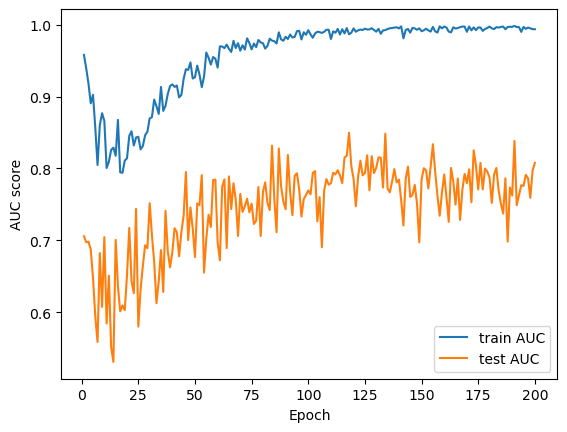

In [35]:
best_auc = 0
best_acc = 0
best_epoch = 0
patience = 5
stop_counter = 0

train_auc_scores = []
test_auc_scores = []
epochs = []

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    train_loss = 0
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        targets = targets.squeeze().long()
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        optimizer.step()

    # Evaluate after each epoch
    print(f"==> Evaluating after epoch {epoch + 1} ...")
    train_metrics = evaluate(train_loader)
    test_metrics = evaluate(test_loader)
    
    print(f"Train AUC: {train_metrics[0]}, Train ACC: {train_metrics[1]}")
    print(f"Test AUC: {test_metrics[0]}, Test ACC: {test_metrics[1]}")

    # Check if AUC score improved
    if test_metrics[0] > best_auc:
        best_auc = test_metrics[0]
        best_acc = test_metrics[1]
        best_epoch = epoch + 1
        print(f"==> Best test AUC and ACC score updated: {best_auc:.4f}, {best_acc:.4f}")
        # Save the model state
        torch.save(model.state_dict(), 'best_model_breastmnist_no_dropout.pth')
    #     stop_counter = 0
    # else:
    #     stop_counter += 1

    # Append AUC scores and epoch numbers
    train_auc_scores.append(train_metrics[0])
    test_auc_scores.append(test_metrics[0])
    epochs.append(epoch+1)

    # Check for early stopping
    # if stop_counter >= patience:
    #     print("Early stopping triggered")
    #     break

print(f"Best test AUC: {best_auc:.4f} and ACC: {best_acc:.4f} achieved at epoch {best_epoch}")

# Plot the train and test AUC scores vs epoch
plt.plot(epochs, train_auc_scores, label='train AUC')
plt.plot(epochs, test_auc_scores, label='test AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC score')
plt.show()